In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import shutil
from PIL import Image
from imgaug import augmenters as iaa
import numpy as np
import pandas as pd
import time
import dask.bag as db
import dask.diagnostics as dd
import random
from termcolor import colored
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2M, EfficientNetV2B0, EfficientNetV2B3, Xception, ResNet50
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, F1Score

2024-10-16 02:44:03.557525: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 02:44:03.557589: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 02:44:03.557962: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 02:44:03.604162: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CWD = os.getcwd()
CWD

'/workspace/Brain-Tumor-Classification'

In [3]:
EPOCHS = 10
SAVE_DIRECTORY = CWD + '/model'

# Load Data

In [13]:
BASE_DIR = os.path.join(CWD, 'dataset', 'processed', 'Training')
TEST_DIR = os.path.join(CWD, 'dataset', 'processed', 'Testing')

In [14]:
# Loop over folders to extract class_names
classes = [class_name for class_name in os.listdir(BASE_DIR)]
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [15]:
# Convert our data to tensorflow dataset by keras.utils.image_dataset_from_directory
train_full = tf.keras.utils.image_dataset_from_directory(
    directory=BASE_DIR,        # Path of base directory
    labels='inferred',         # to generate labels from the directory structure
    label_mode='categorical',  # type of labels
    class_names=classes,       # list of class_names
    seed=42,                   # Optional random seed for shuffling and transformations
    batch_size=32,              # Define batch size
    image_size=(256, 256)      # Size to resize images to after they are read from disk
 )

Found 5712 files belonging to 4 classes.


In [19]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    labels='inferred',
    label_mode = 'categorical',
    class_names=classes,
    seed=42,
    batch_size=32,
    image_size=(256,256)
)

Found 1311 files belonging to 4 classes.


In [20]:
train_full = train_full.prefetch(tf.data.AUTOTUNE)

In [21]:
# Counting number of all batches in dataset
num_of_full_train_batches = len(list(train_full))
print(colored(f'Number of batches in train_full : {num_of_full_train_batches}', 'black', attrs=['bold']))

# Define variable to store number of batches for train dataset
num_train_batches = int(num_of_full_train_batches * 0.70)
# Define variable to store number of batches for validation and test dataset
num_valid_test_batches = num_of_full_train_batches - num_train_batches

# Print the TARGET : number of batches for train, validation and test dataset to each
print(colored(' Target : ', 'green', attrs=['bold']))
print('-'*35)
print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

Number of batches in train_full : 179
 Target : 
-----------------------------------
Number of  Train  batches : 125
Number of Validation batches : 27
Number of Test batches : 27


In [22]:
# Apply above settings to main dataset to split to train, validation and test dataset
train_ds = train_full.take(num_train_batches)
remain_ds = train_full.skip(num_train_batches)
valid_ds = remain_ds.take(num_valid_test_batches)
# test_ds = remain_ds.skip(num_valid_test_batches//2)

In [23]:
train_ds = train_ds.shuffle(buffer_size=3)

In [24]:
def build_model_trainable_last25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze first 75% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:(int(0.75 * total_layers))]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model    

In [25]:
def build_model_trainable_first25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze last 75% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[(int(0.75 * total_layers)):]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model  

In [34]:
def build_model_not_trainable(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model

In [27]:
def train(model, model_name, train_ds, valid_ds, epochs, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    saving_path = os.path.join(save_directory, f'model_{model_name}.h5')

    # Model CheckPoint Call-Back, to save best model parameters as a .keras file
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(saving_path, monitor='val_accuracy', save_best_only=True)

    # Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
    earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    # ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Model training
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data = valid_ds,
        callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
    )

    return model, history

In [28]:
def plot(model, history):
    # Convert result of training to DataFrame
    result = pd.DataFrame(history.history)

    # Define a X variable to store range of epochs
    x = np.arange(len(result))

    # Create a plot with 3 row and 1 col with size of (15, 12)
    fig, ax = plt.subplots(2, 1, figsize=(15, 12))

    # AX0 : Loss
    ax[0].plot(x, result.loss, label='loss', linewidth=3)
    ax[0].plot(x, result.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
    ax[0].set_title('Loss', fontsize=20)
    ax[0].set_xticks(np.arange(0, len(x), 2))
    ax[0].legend()

    #  AX1 : Loss
    ax[1].plot(x, result.accuracy, label='accuracy', linewidth=2)
    ax[1].plot(x, result.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
    ax[1].set_title('Accuracy', fontsize=20)
    ax[1].set_xticks(np.arange(0, len(x), 2))
    ax[1].legend()


    # Evaluate model
    test_loss, test_acc, test_f1score = model.evaluate(test_ds, verbose=1)


    # Confusion Matrix
    # Get the class names from the dataset
    class_names = sorted(classes)

    # Make predictions
    y_pred = []
    y_true = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.show()

    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5)
    print(cr)

    return history, test_loss, test_acc, test_f1score


In [29]:
def result(model_name, test_loss, test_acc, test_f1score, result_dict):
    result_dict['Model Name'].append(model_name)
    result_dict['Test Loss'].append(test_loss)
    result_dict['Test Accuracy'].append(test_acc)
    result_dict['Test F1Score'].append(test_f1score)

result_dict = {
    'Model Name': [],
    'Test Loss': [],
    'Test Accuracy': [],
    'Test F1Score': []
}

# Model Training

## Standard

### EfficientNetV2B0

#### trainable first25

In [30]:
model_name = 'efficientnetv2b0_standart_trainable_first25'
input_shape = (256,256,3)

std_b0_tf25 = build_model_trainable_first25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tf25, history_std_b0_tf25 = train(std_b0_tf25, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)

24274472/24274472 [==============================] - 1s 0us/step
Epoch 1/10


2024-10-16 02:48:28.233243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-10-16 02:48:30.693217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-10-16 02:48:30.800079: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-16 02:48:32.774255: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f97d192cf00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-16 02:48:32.774295: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-16 02:48:32.782752: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set 

125/125 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.7245 - f1_score: 0.7152

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 43s 103ms/step - loss: 0.6840 - accuracy: 0.7245 - f1_score: 0.7152 - val_loss: 0.2848 - val_accuracy: 0.8978 - val_f1_score: 0.8925 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 11s 87ms/step - loss: 0.2870 - accuracy: 0.8978 - f1_score: 0.8951 - val_loss: 0.2294 - val_accuracy: 0.9130 - val_f1_score: 0.9065 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 11s 88ms/step - loss: 0.1503 - accuracy: 0.9485 - f1_score: 0.9474 - val_loss: 0.0892 - val_accuracy: 0.9696 - val_f1_score: 0.9678 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 10s 81ms/step - loss: 0.0816 - accuracy: 0.9753 - f1_score: 0.9747 - val_loss: 0.1032 - val_accuracy: 0.9690 - val_f1_score: 0.9669 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 12s 93ms/step - loss: 0.0537 - accuracy: 0.9822 - f1_score: 0.9820 - val_loss: 0.0606 - val_accuracy: 0.9801 - val_f1_score: 0.9790 - lr: 1.0000

1/1 [==============================] - 1s 1s/step


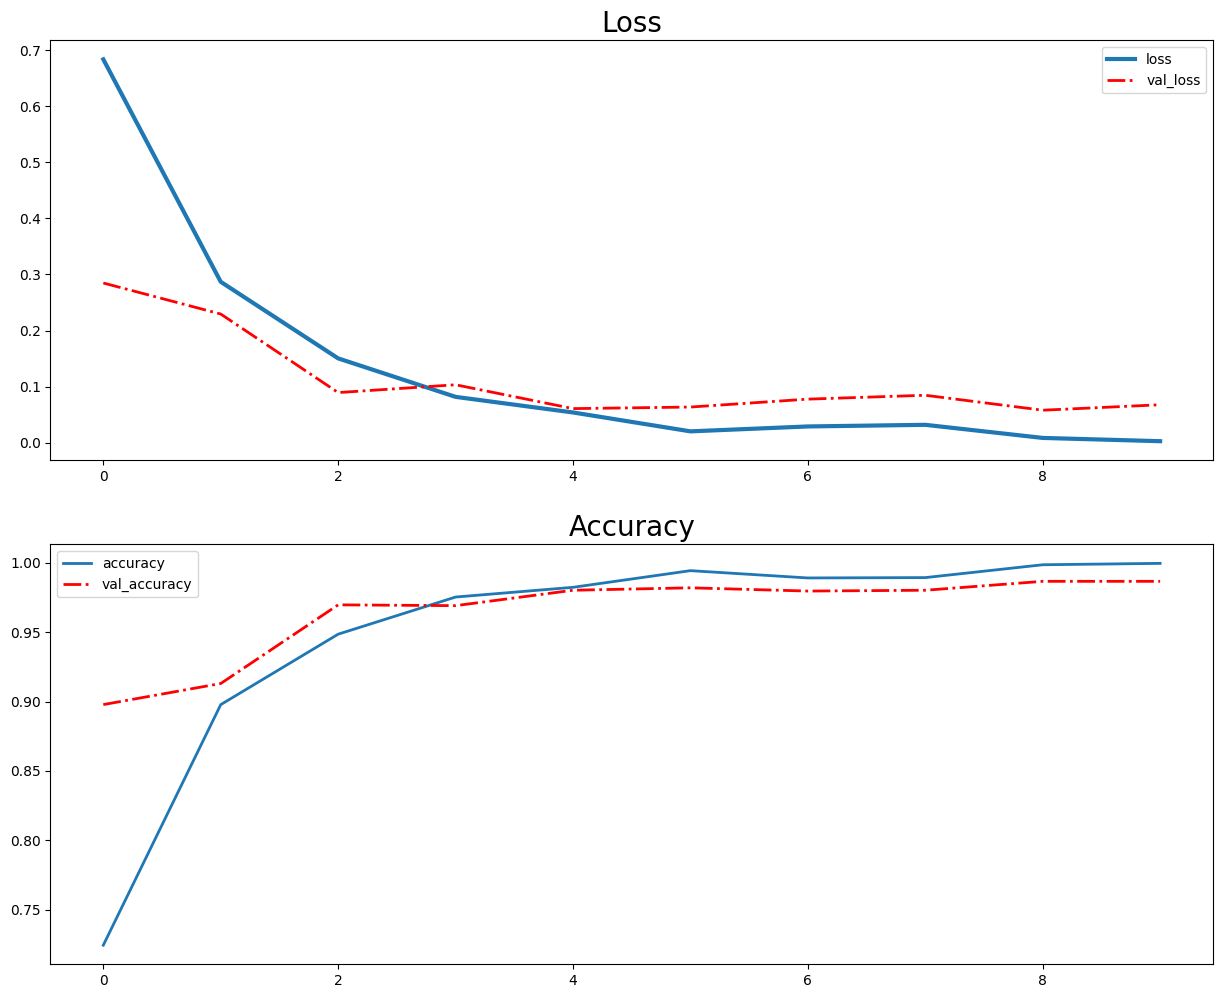

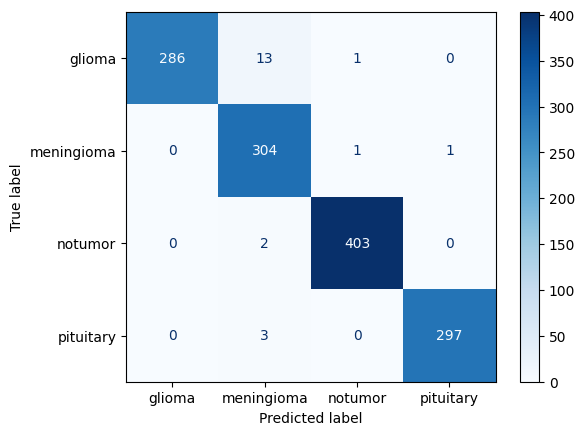

Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.95333   0.97611       300
           1    0.94410   0.99346   0.96815       306
           2    0.99506   0.99506   0.99506       405
           3    0.99664   0.99000   0.99331       300

    accuracy                        0.98398      1311
   macro avg    0.98395   0.98296   0.98316      1311
weighted avg    0.98466   0.98398   0.98404      1311



In [31]:
history_std_b0_tf25, test_loss, test_acc, test_f1score = plot(std_b0_tf25, history_std_b0_tf25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### trainable last25

Epoch 1/10


2024-10-16 02:52:43.922092: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


123/125 [============================>.] - ETA: 0s - loss: 0.6443 - accuracy: 0.7444 - f1_score: 0.7348

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 19s 66ms/step - loss: 0.6401 - accuracy: 0.7460 - f1_score: 0.7367 - val_loss: 0.2457 - val_accuracy: 0.9118 - val_f1_score: 0.9079 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 25s 202ms/step - loss: 0.2567 - accuracy: 0.9065 - f1_score: 0.9035 - val_loss: 0.1578 - val_accuracy: 0.9428 - val_f1_score: 0.9390 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 45s 345ms/step - loss: 0.1367 - accuracy: 0.9515 - f1_score: 0.9502 - val_loss: 0.1117 - val_accuracy: 0.9644 - val_f1_score: 0.9626 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 16s 118ms/step - loss: 0.0818 - accuracy: 0.9722 - f1_score: 0.9714 - val_loss: 0.1126 - val_accuracy: 0.9685 - val_f1_score: 0.9660 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 12s 97ms/step - loss: 0.0554 - accuracy: 0.9768 - f1_score: 0.9759 - val_loss: 0.1176 - val_accuracy: 0.9685 - val_f1_score: 0.9668 - lr: 1.00

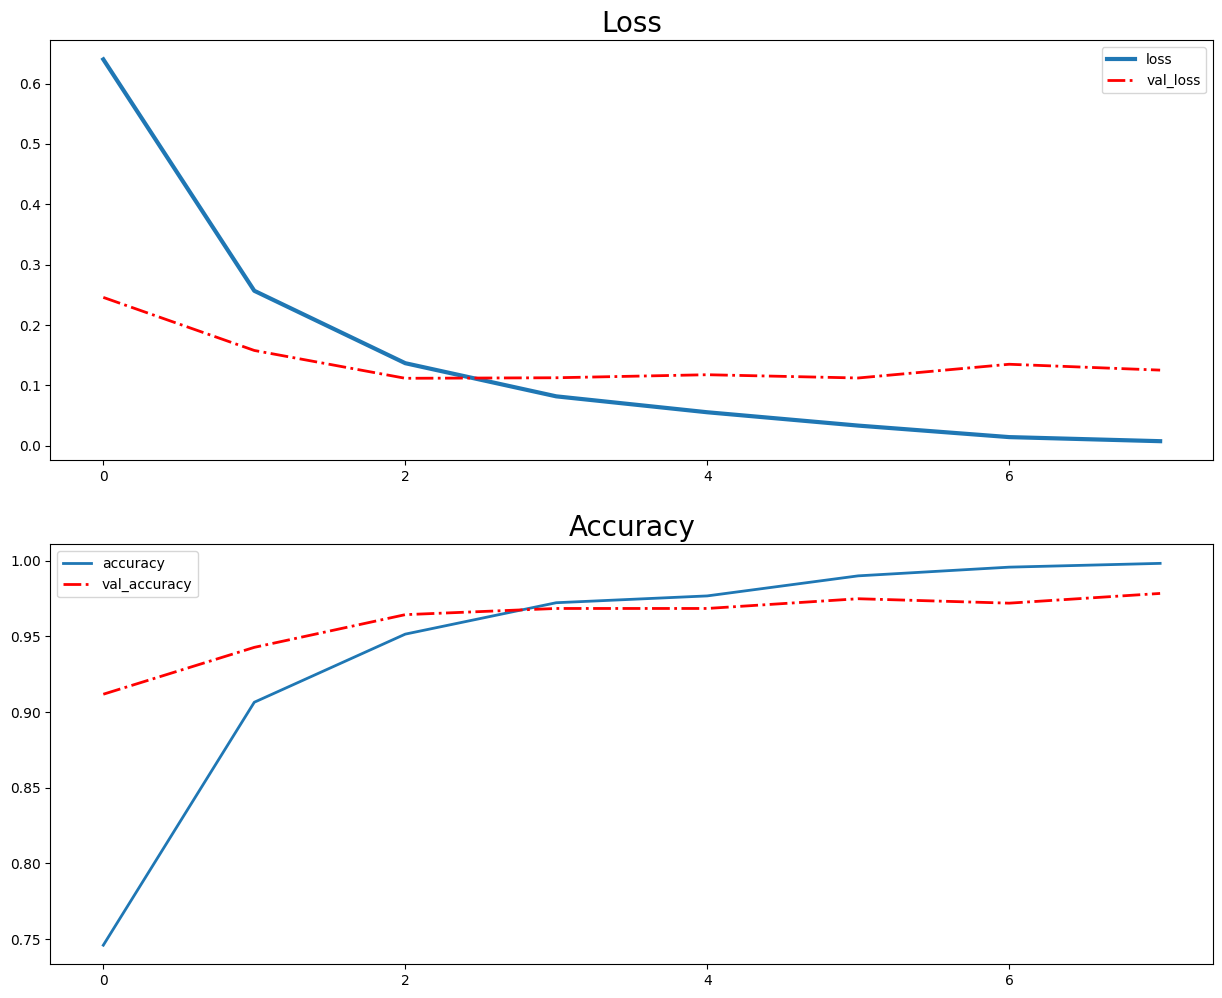

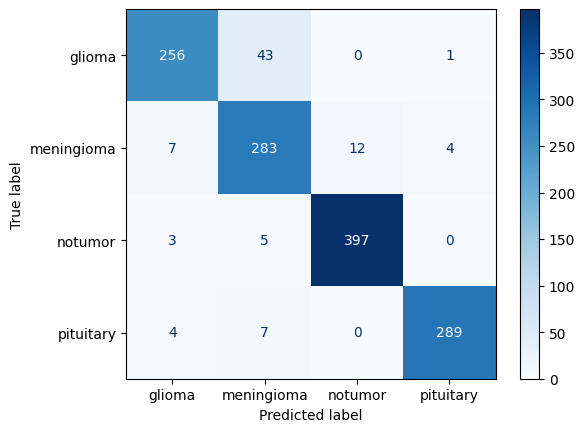

Classification Report
              precision    recall  f1-score   support

           0    0.94815   0.85333   0.89825       300
           1    0.83728   0.92484   0.87888       306
           2    0.97066   0.98025   0.97543       405
           3    0.98299   0.96333   0.97306       300

    accuracy                        0.93440      1311
   macro avg    0.93477   0.93044   0.93141      1311
weighted avg    0.93720   0.93440   0.93469      1311



In [32]:
model_name = 'efficientnetv2b0_standart_trainable_last25'
input_shape = (256,256,3)

std_b0_tl25 = build_model_trainable_last25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tl25, history_std_b0_tl25 = train(std_b0_tl25, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_b0_tl25, test_loss, test_acc, test_f1score = plot(std_b0_tl25, history_std_b0_tl25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### not trainable

Epoch 1/10
123/125 [============================>.] - ETA: 0s - loss: 0.9664 - accuracy: 0.6014 - f1_score: 0.5841

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 12s 50ms/step - loss: 0.9634 - accuracy: 0.6028 - f1_score: 0.5861 - val_loss: 0.5609 - val_accuracy: 0.8224 - val_f1_score: 0.8098 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 5s 40ms/step - loss: 0.5708 - accuracy: 0.7925 - f1_score: 0.7854 - val_loss: 0.3958 - val_accuracy: 0.8598 - val_f1_score: 0.8493 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 5s 39ms/step - loss: 0.4561 - accuracy: 0.8375 - f1_score: 0.8319 - val_loss: 0.3177 - val_accuracy: 0.8884 - val_f1_score: 0.8818 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 5s 39ms/step - loss: 0.3892 - accuracy: 0.8593 - f1_score: 0.8549 - val_loss: 0.2838 - val_accuracy: 0.9001 - val_f1_score: 0.8942 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 5s 39ms/step - loss: 0.3536 - accuracy: 0.8708 - f1_score: 0.8664 - val_loss: 0.2563 - val_accuracy: 0.9106 - val_f1_score: 0.9049 - lr: 1.0000e-04


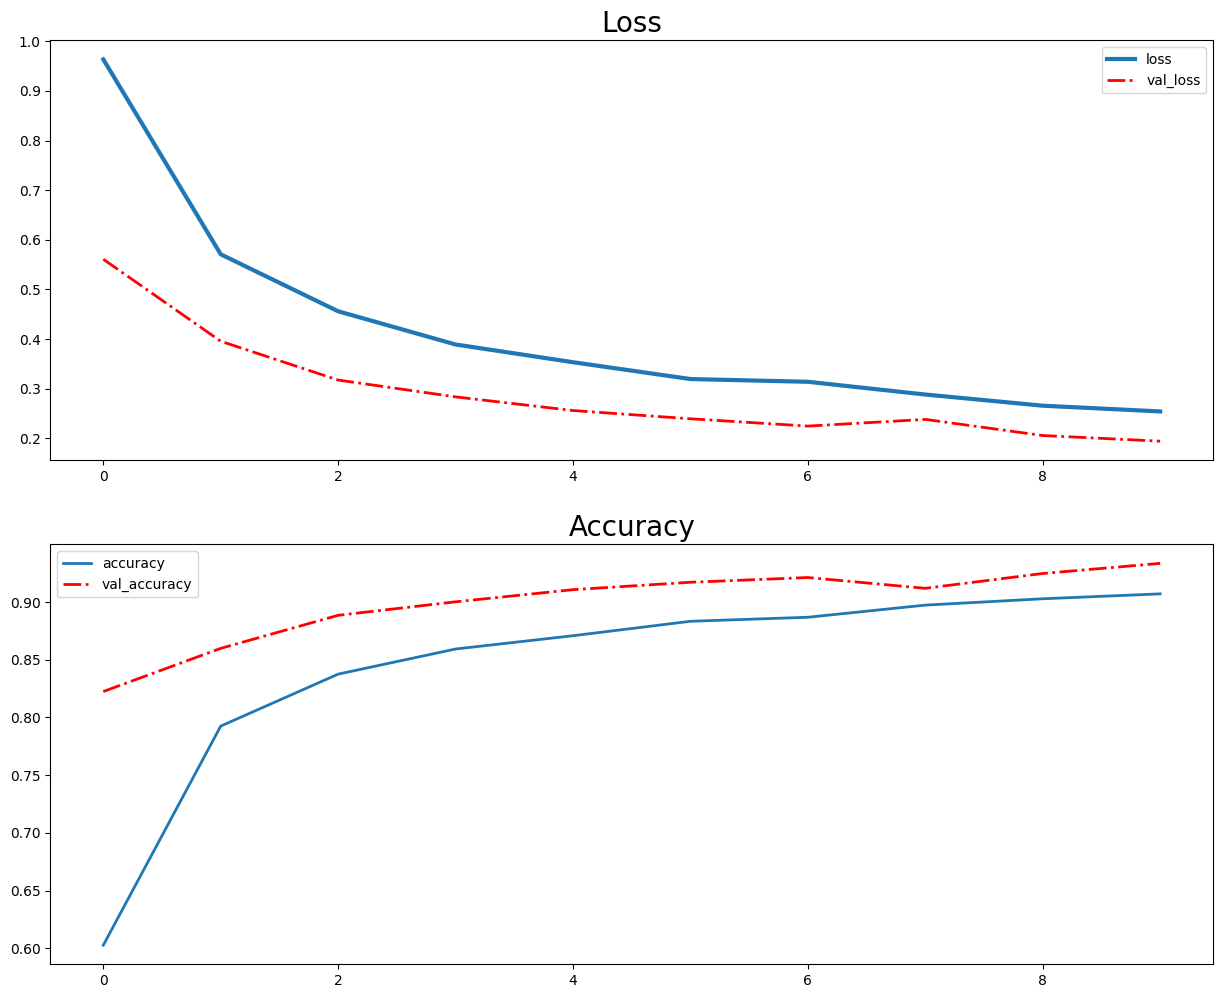

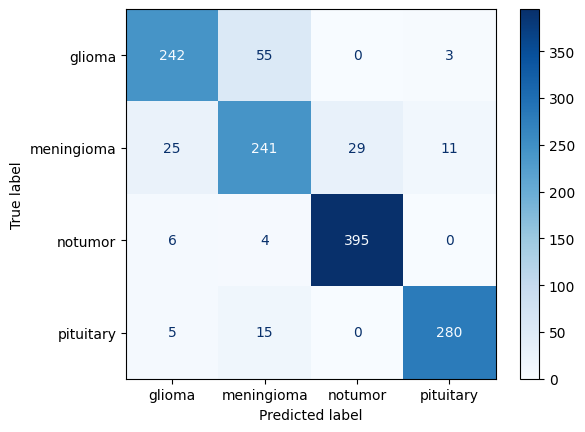

Classification Report
              precision    recall  f1-score   support

           0    0.87050   0.80667   0.83737       300
           1    0.76508   0.78758   0.77617       306
           2    0.93160   0.97531   0.95296       405
           3    0.95238   0.93333   0.94276       300

    accuracy                        0.88330      1311
   macro avg    0.87989   0.87572   0.87731      1311
weighted avg    0.88351   0.88330   0.88291      1311



In [35]:
model_name = 'efficientnetv2b0_standart_not_trainable'
input_shape = (256,256,3)

std_b0_nt = build_model_not_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_nt, history_std_b0_nt = train(std_b0_nt, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_b0_nt, test_loss, test_acc, test_f1score = plot(std_b0_nt, history_std_b0_nt)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

### EfficientNetV2B3

#### trainable first25

52606240/52606240 [==============================] - 2s 0us/step
Epoch 1/10


2024-10-16 02:57:44.049162: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.7793 - f1_score: 0.7723

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 59s 139ms/step - loss: 0.5888 - accuracy: 0.7793 - f1_score: 0.7723 - val_loss: 0.2059 - val_accuracy: 0.9229 - val_f1_score: 0.9188 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 15s 118ms/step - loss: 0.1730 - accuracy: 0.9390 - f1_score: 0.9374 - val_loss: 0.1024 - val_accuracy: 0.9661 - val_f1_score: 0.9645 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 16s 124ms/step - loss: 0.0734 - accuracy: 0.9715 - f1_score: 0.9705 - val_loss: 0.0483 - val_accuracy: 0.9860 - val_f1_score: 0.9851 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 14s 110ms/step - loss: 0.0556 - accuracy: 0.9810 - f1_score: 0.9803 - val_loss: 0.0858 - val_accuracy: 0.9737 - val_f1_score: 0.9723 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 13s 107ms/step - loss: 0.0419 - accuracy: 0.9875 - f1_score: 0.9872 - val_loss: 0.0779 - val_accuracy: 0.9784 - val_f1_score: 0.9774 - lr: 1.

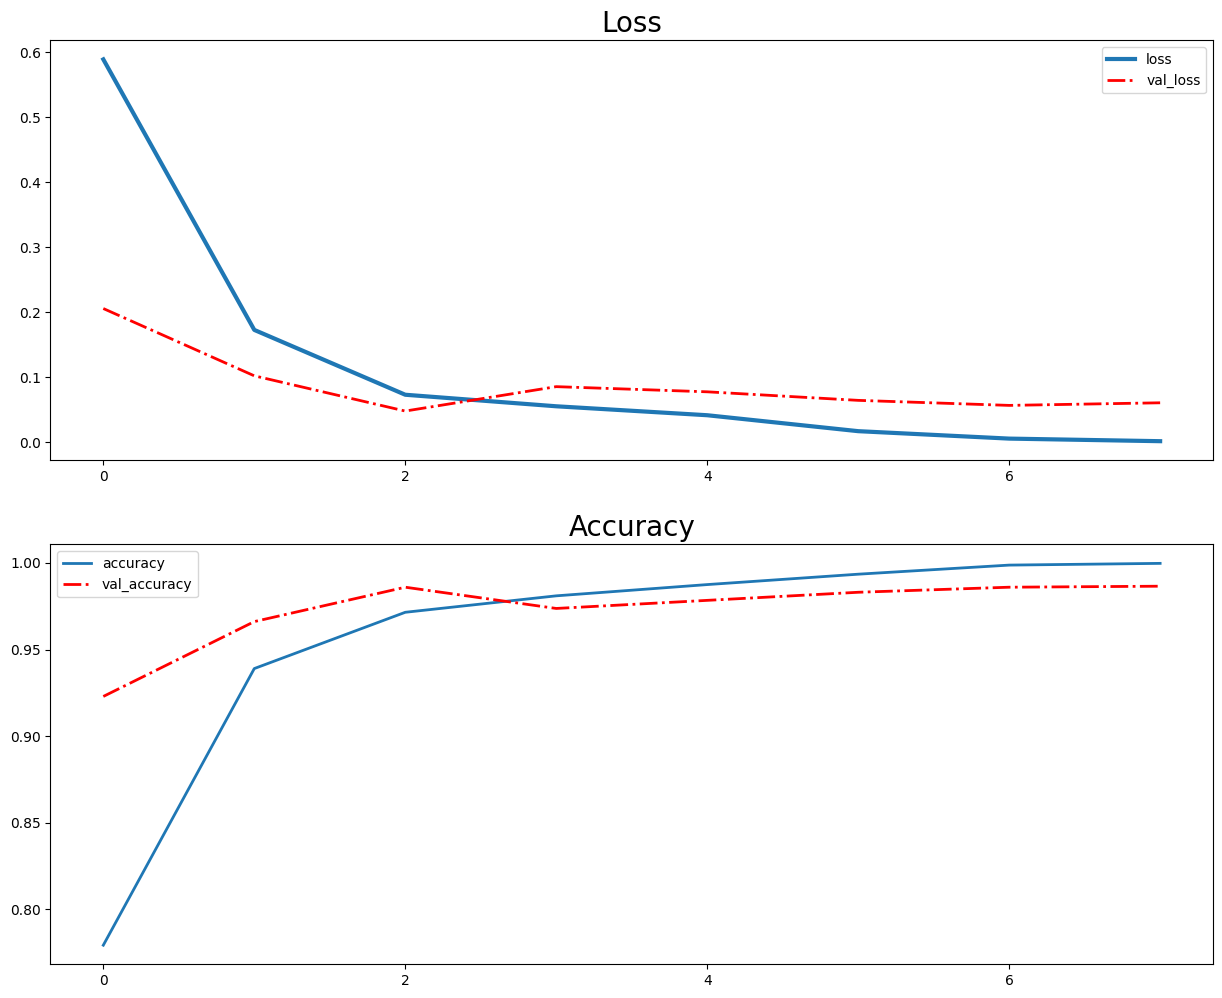

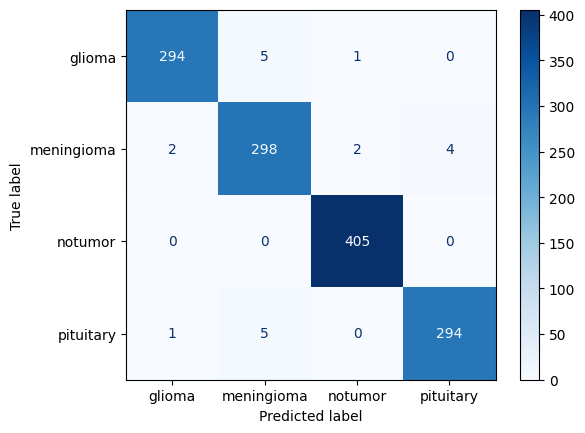

Classification Report
              precision    recall  f1-score   support

           0    0.98990   0.98000   0.98492       300
           1    0.96753   0.97386   0.97068       306
           2    0.99265   1.00000   0.99631       405
           3    0.98658   0.98000   0.98328       300

    accuracy                        0.98474      1311
   macro avg    0.98416   0.98346   0.98380      1311
weighted avg    0.98477   0.98474   0.98474      1311



In [36]:
model_name = 'efficientnetv2b3_standart_trainable_first25'
input_shape = (256,256,3)

std_b3_tf25 = build_model_trainable_first25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tf25, history_std_b3_tf25 = train(std_b3_tf25, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_b3_tf25, test_loss, test_acc, test_f1score = plot(std_b3_tf25, history_std_b3_tf25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### trainable last25

Epoch 1/10


2024-10-16 03:00:28.114351: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.7890 - f1_score: 0.7808

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 28s 79ms/step - loss: 0.5532 - accuracy: 0.7890 - f1_score: 0.7808 - val_loss: 0.2217 - val_accuracy: 0.9165 - val_f1_score: 0.9127 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 8s 62ms/step - loss: 0.1942 - accuracy: 0.9268 - f1_score: 0.9248 - val_loss: 0.1720 - val_accuracy: 0.9311 - val_f1_score: 0.9296 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 9s 70ms/step - loss: 0.0771 - accuracy: 0.9728 - f1_score: 0.9720 - val_loss: 0.1739 - val_accuracy: 0.9486 - val_f1_score: 0.9460 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 9s 70ms/step - loss: 0.0497 - accuracy: 0.9840 - f1_score: 0.9836 - val_loss: 0.1324 - val_accuracy: 0.9614 - val_f1_score: 0.9594 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 9s 70ms/step - loss: 0.0209 - accuracy: 0.9925 - f1_score: 0.9922 - val_loss: 0.1306 - val_accuracy: 0.9755 - val_f1_score: 0.9739 - lr: 1.0000e-04


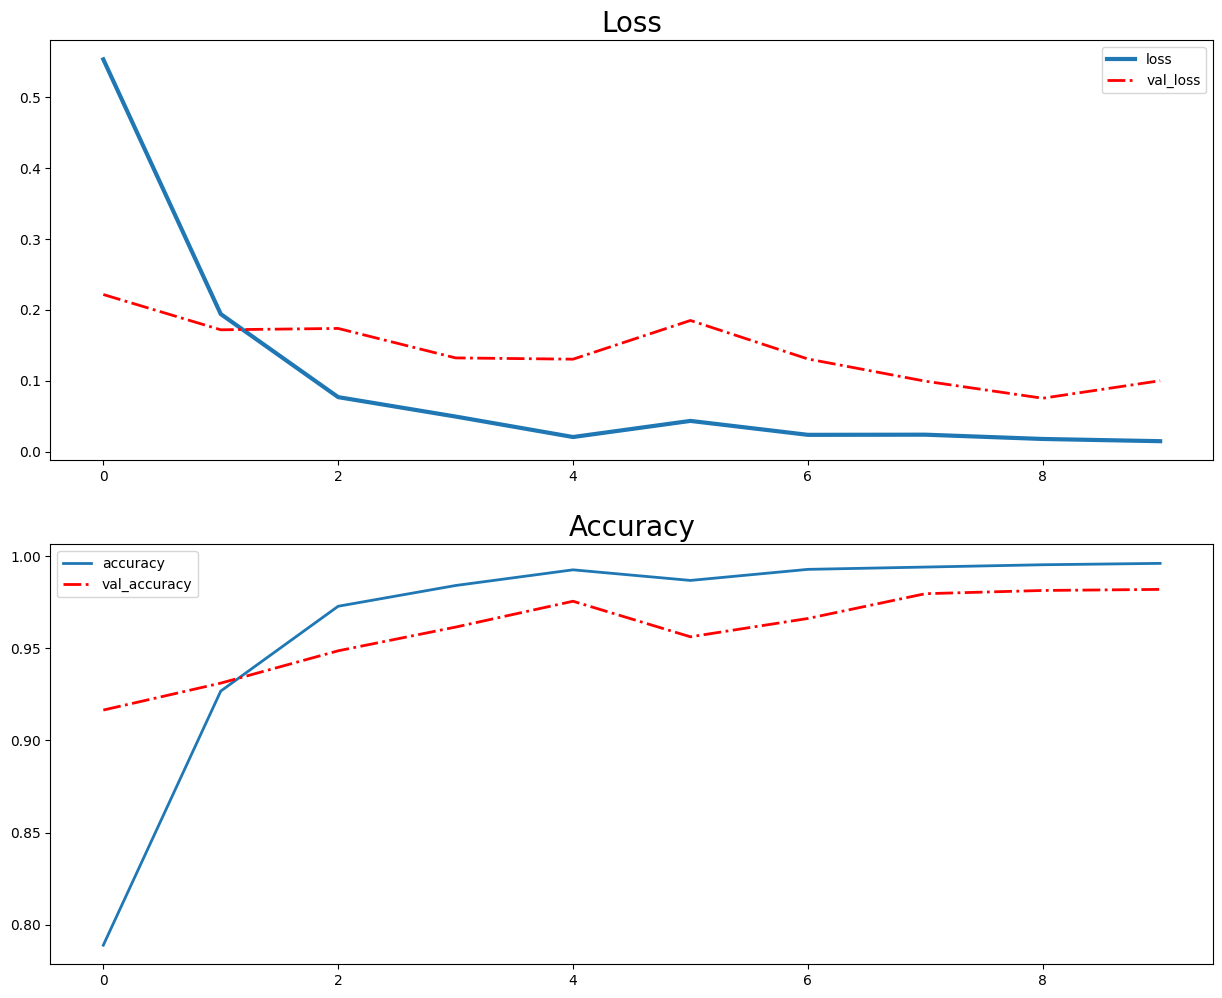

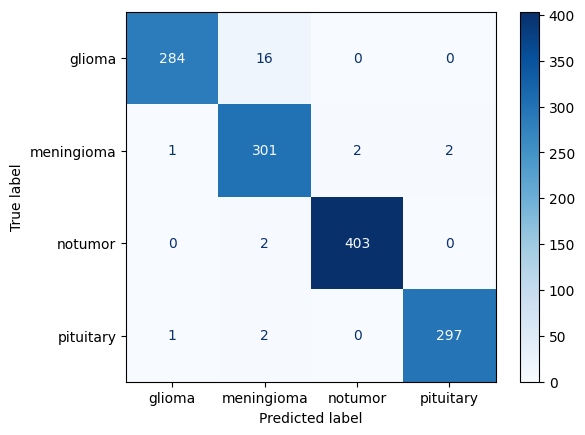

Classification Report
              precision    recall  f1-score   support

           0    0.99301   0.94667   0.96928       300
           1    0.93769   0.98366   0.96013       306
           2    0.99506   0.99506   0.99506       405
           3    0.99331   0.99000   0.99165       300

    accuracy                        0.98017      1311
   macro avg    0.97977   0.97885   0.97903      1311
weighted avg    0.98080   0.98017   0.98023      1311



In [37]:
model_name = 'efficientnetv2b3_standart_trainable_last25'
input_shape = (256,256,3)

std_b3_tl25 = build_model_trainable_last25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tl25, history_std_b3_tl25 = train(std_b3_tl25, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_b3_tl25, test_loss, test_acc, test_f1score = plot(std_b3_tl25, history_std_b3_tl25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### not trainable

Epoch 1/10
124/125 [============================>.] - ETA: 0s - loss: 0.8987 - accuracy: 0.6517 - f1_score: 0.6397

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 17s 65ms/step - loss: 0.8957 - accuracy: 0.6532 - f1_score: 0.6412 - val_loss: 0.5014 - val_accuracy: 0.8201 - val_f1_score: 0.8074 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 6s 50ms/step - loss: 0.5100 - accuracy: 0.8127 - f1_score: 0.8056 - val_loss: 0.3752 - val_accuracy: 0.8674 - val_f1_score: 0.8598 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 6s 50ms/step - loss: 0.4178 - accuracy: 0.8432 - f1_score: 0.8380 - val_loss: 0.3150 - val_accuracy: 0.8884 - val_f1_score: 0.8819 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 7s 52ms/step - loss: 0.3634 - accuracy: 0.8715 - f1_score: 0.8673 - val_loss: 0.2947 - val_accuracy: 0.8937 - val_f1_score: 0.8874 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 7s 56ms/step - loss: 0.3266 - accuracy: 0.8827 - f1_score: 0.8793 - val_loss: 0.2606 - val_accuracy: 0.9001 - val_f1_score: 0.8940 - lr: 1.0000e-04


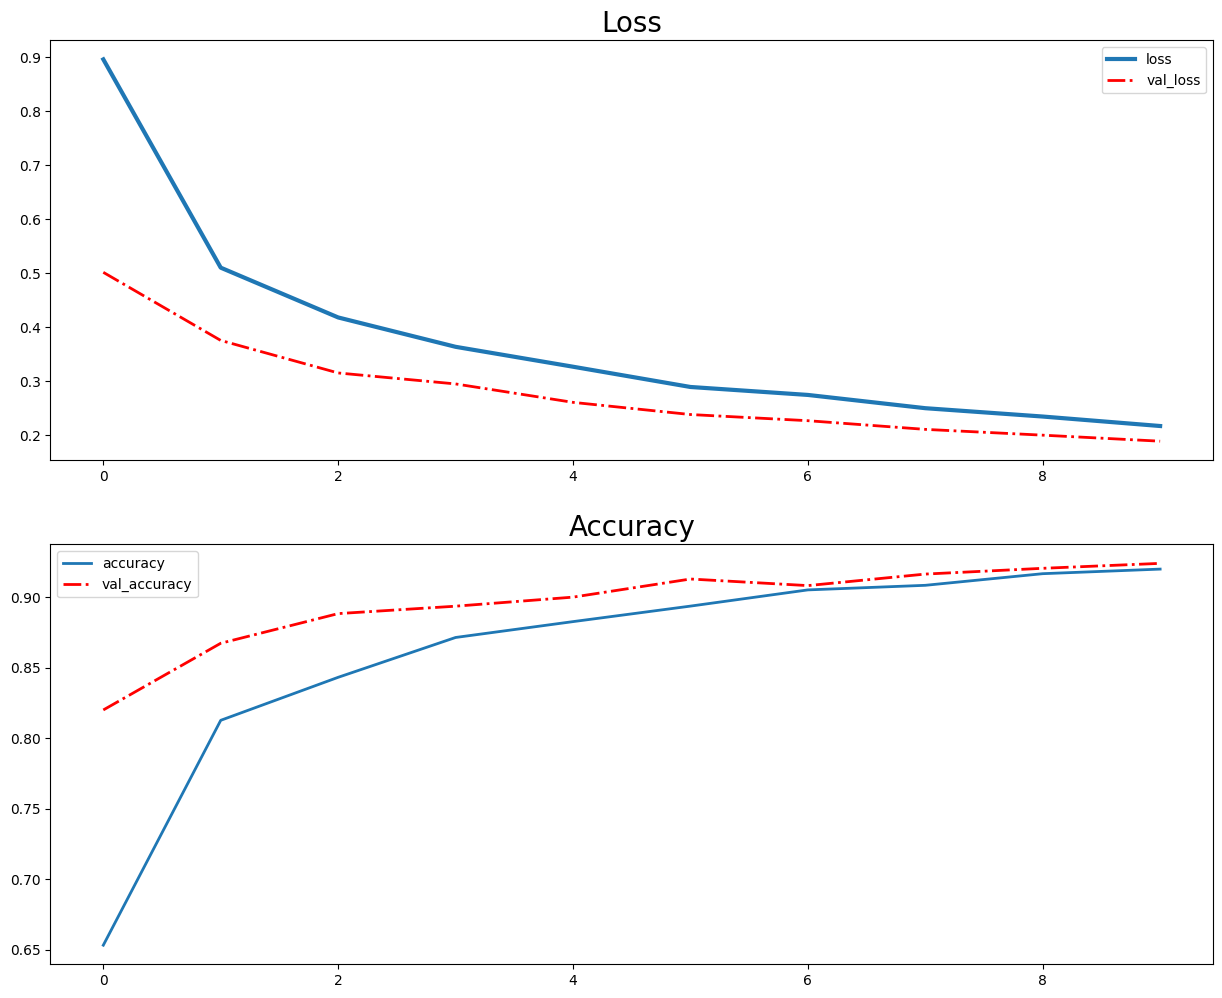

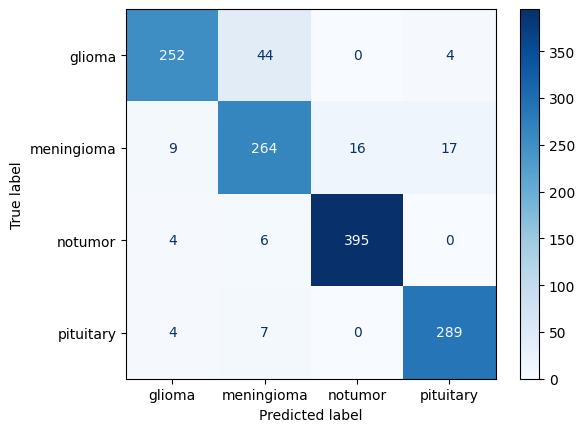

Classification Report
              precision    recall  f1-score   support

           0    0.93680   0.84000   0.88576       300
           1    0.82243   0.86275   0.84211       306
           2    0.96107   0.97531   0.96814       405
           3    0.93226   0.96333   0.94754       300

    accuracy                        0.91533      1311
   macro avg    0.91314   0.91035   0.91089      1311
weighted avg    0.91656   0.91533   0.91516      1311



In [38]:
model_name = 'efficientnetv2b3_standart_not_trainable'
input_shape = (256,256,3)

std_b3_nt = build_model_not_trainable(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_nt, history_std_b3_nt = train(std_b3_nt, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_b3_nt, test_loss, test_acc, test_f1score = plot(std_b3_nt, history_std_b3_nt)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

### EfficientNetV2M

#### trainable first25

214201816/214201816 [==============================] - 6s 0us/step
Epoch 1/10


2024-10-16 03:04:26.205995: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.5939 - accuracy: 0.7803 - f1_score: 0.7752

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 143s 397ms/step - loss: 0.5939 - accuracy: 0.7803 - f1_score: 0.7752 - val_loss: 0.2814 - val_accuracy: 0.9065 - val_f1_score: 0.9047 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 45s 355ms/step - loss: 0.1591 - accuracy: 0.9513 - f1_score: 0.9501 - val_loss: 0.0774 - val_accuracy: 0.9725 - val_f1_score: 0.9711 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 30s 239ms/step - loss: 0.0807 - accuracy: 0.9762 - f1_score: 0.9757 - val_loss: 0.0984 - val_accuracy: 0.9708 - val_f1_score: 0.9686 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 24s 194ms/step - loss: 0.0480 - accuracy: 0.9875 - f1_score: 0.9873 - val_loss: 0.2006 - val_accuracy: 0.9480 - val_f1_score: 0.9432 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 24s 190ms/step - loss: 0.0480 - accuracy: 0.9870 - f1_score: 0.9868 - val_loss: 0.1336 - val_accuracy: 0.9638 - val_f1_score: 0.9620 - lr: 1

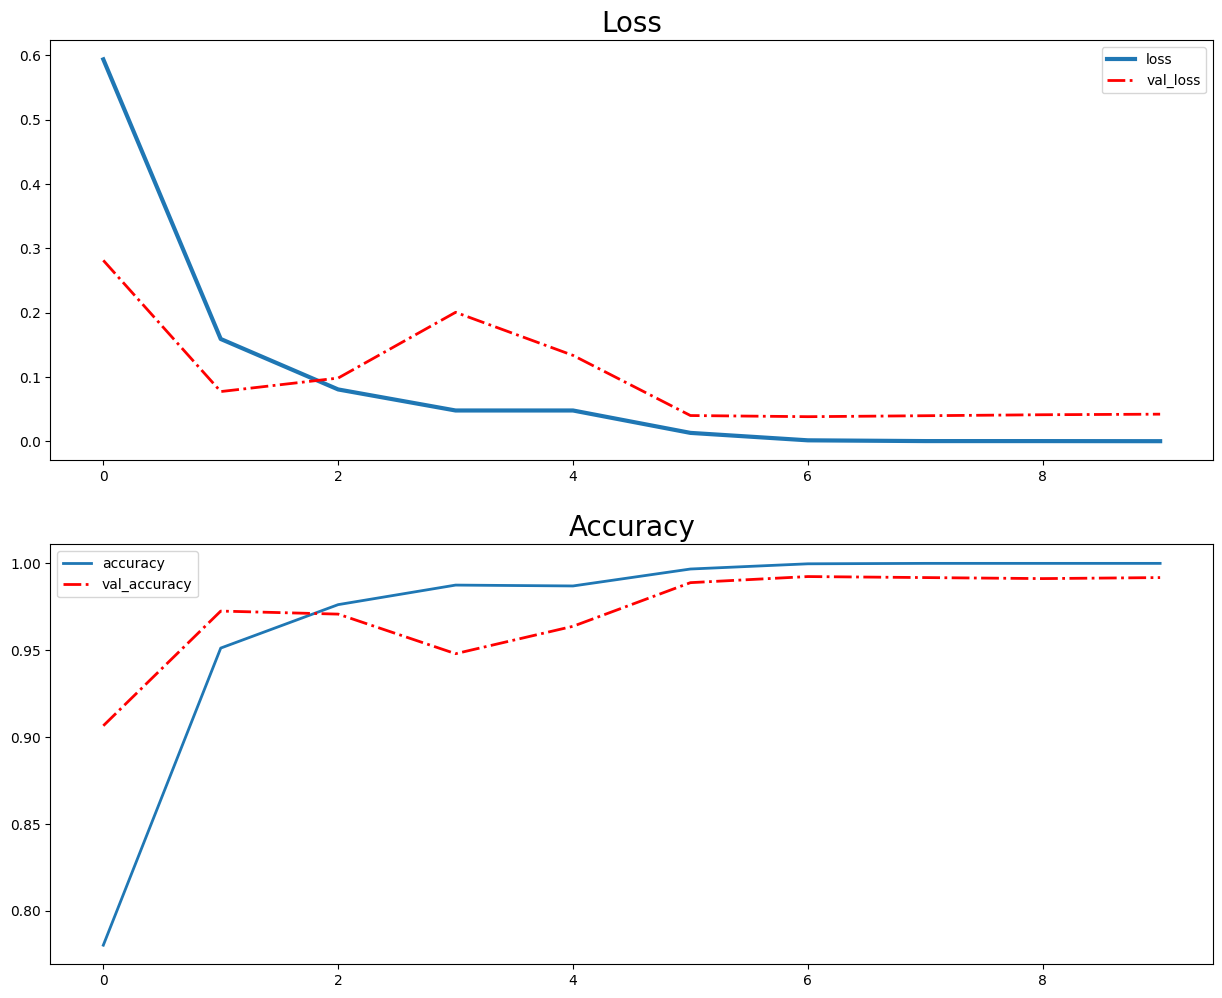

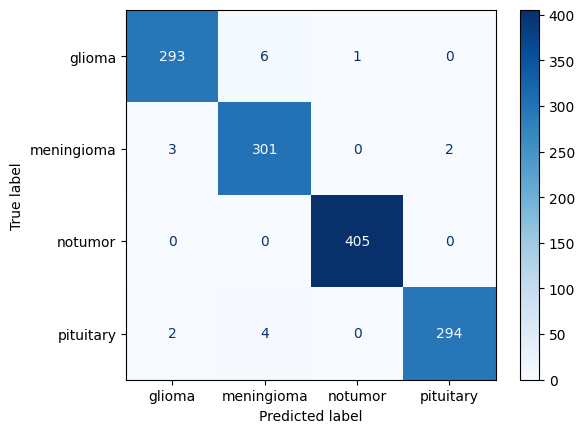

Classification Report
              precision    recall  f1-score   support

           0    0.98322   0.97667   0.97993       300
           1    0.96785   0.98366   0.97569       306
           2    0.99754   1.00000   0.99877       405
           3    0.99324   0.98000   0.98658       300

    accuracy                        0.98627      1311
   macro avg    0.98546   0.98508   0.98524      1311
weighted avg    0.98635   0.98627   0.98628      1311



In [39]:
model_name = 'efficientnetv2m_standart_trainable_first25'
input_shape = (256,256,3)

std_m_tf25 = build_model_trainable_first25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tf25, history_std_m_tf25 = train(std_m_tf25, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_m_tf25, test_loss, test_acc, test_f1score = plot(std_m_tf25, history_std_m_tf25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### trainable last25

Epoch 1/10


2024-10-16 03:11:42.397089: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.8148 - f1_score: 0.8090

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 52s 168ms/step - loss: 0.4884 - accuracy: 0.8148 - f1_score: 0.8090 - val_loss: 0.3336 - val_accuracy: 0.8814 - val_f1_score: 0.8741 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 17s 137ms/step - loss: 0.1854 - accuracy: 0.9352 - f1_score: 0.9335 - val_loss: 0.1703 - val_accuracy: 0.9375 - val_f1_score: 0.9309 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 17s 133ms/step - loss: 0.0939 - accuracy: 0.9703 - f1_score: 0.9693 - val_loss: 0.0961 - val_accuracy: 0.9708 - val_f1_score: 0.9689 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 14s 113ms/step - loss: 0.0417 - accuracy: 0.9868 - f1_score: 0.9863 - val_loss: 0.1508 - val_accuracy: 0.9609 - val_f1_score: 0.9588 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 14s 115ms/step - loss: 0.0458 - accuracy: 0.9852 - f1_score: 0.9848 - val_loss: 0.0921 - val_accuracy: 0.9708 - val_f1_score: 0.9689 - lr: 1.

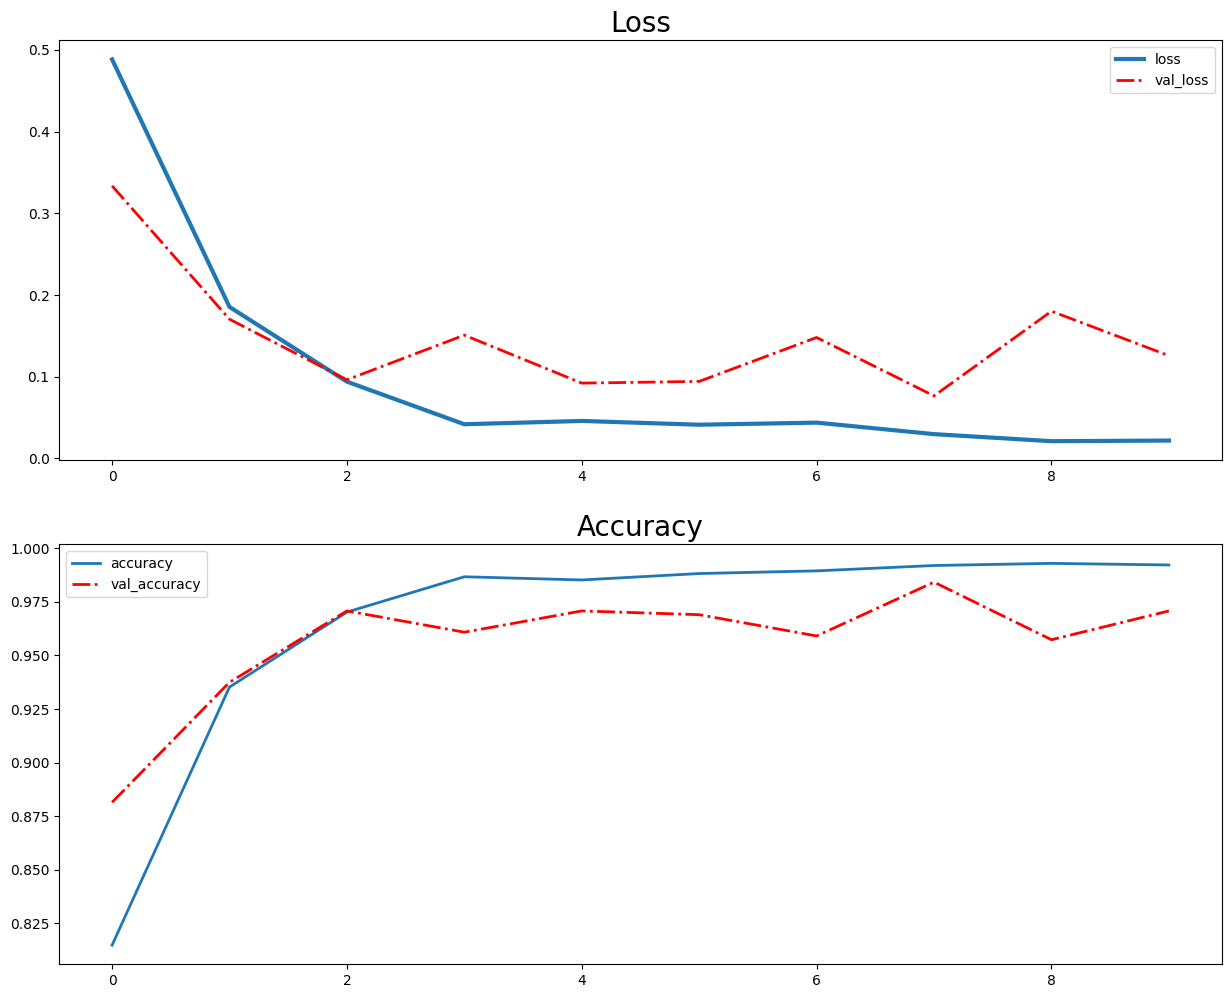

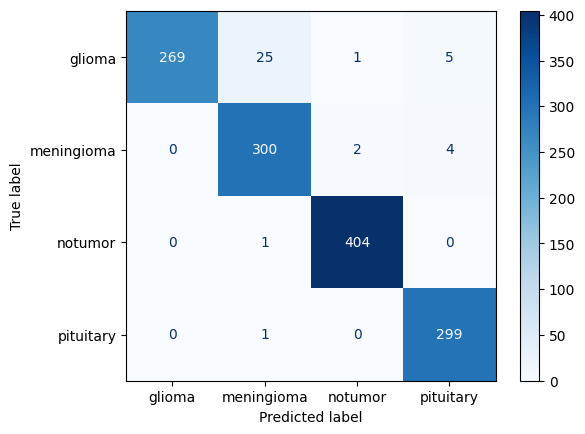

Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.89667   0.94552       300
           1    0.91743   0.98039   0.94787       306
           2    0.99263   0.99753   0.99507       405
           3    0.97078   0.99667   0.98355       300

    accuracy                        0.97025      1311
   macro avg    0.97021   0.96781   0.96800      1311
weighted avg    0.97176   0.97025   0.97008      1311



In [40]:
model_name = 'efficientnetv2m_standart_trainable_last25'
input_shape = (256,256,3)

std_m_tl25 = build_model_trainable_last25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tl25, history_std_m_tl25 = train(std_m_tl25, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_m_tl25, test_loss, test_acc, test_f1score = plot(std_m_tl25, history_std_m_tl25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### not trainable

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 0.9547 - accuracy: 0.6162 - f1_score: 0.5996

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 30s 122ms/step - loss: 0.9547 - accuracy: 0.6162 - f1_score: 0.5996 - val_loss: 0.6272 - val_accuracy: 0.7739 - val_f1_score: 0.7585 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 12s 92ms/step - loss: 0.6087 - accuracy: 0.7688 - f1_score: 0.7605 - val_loss: 0.4809 - val_accuracy: 0.8160 - val_f1_score: 0.8029 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 12s 93ms/step - loss: 0.5105 - accuracy: 0.8133 - f1_score: 0.8077 - val_loss: 0.4186 - val_accuracy: 0.8335 - val_f1_score: 0.8214 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 12s 93ms/step - loss: 0.4347 - accuracy: 0.8365 - f1_score: 0.8315 - val_loss: 0.3699 - val_accuracy: 0.8610 - val_f1_score: 0.8508 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 10s 81ms/step - loss: 0.4040 - accuracy: 0.8468 - f1_score: 0.8418 - val_loss: 0.3552 - val_accuracy: 0.8563 - val_f1_score: 0.8463 - lr: 1.0000

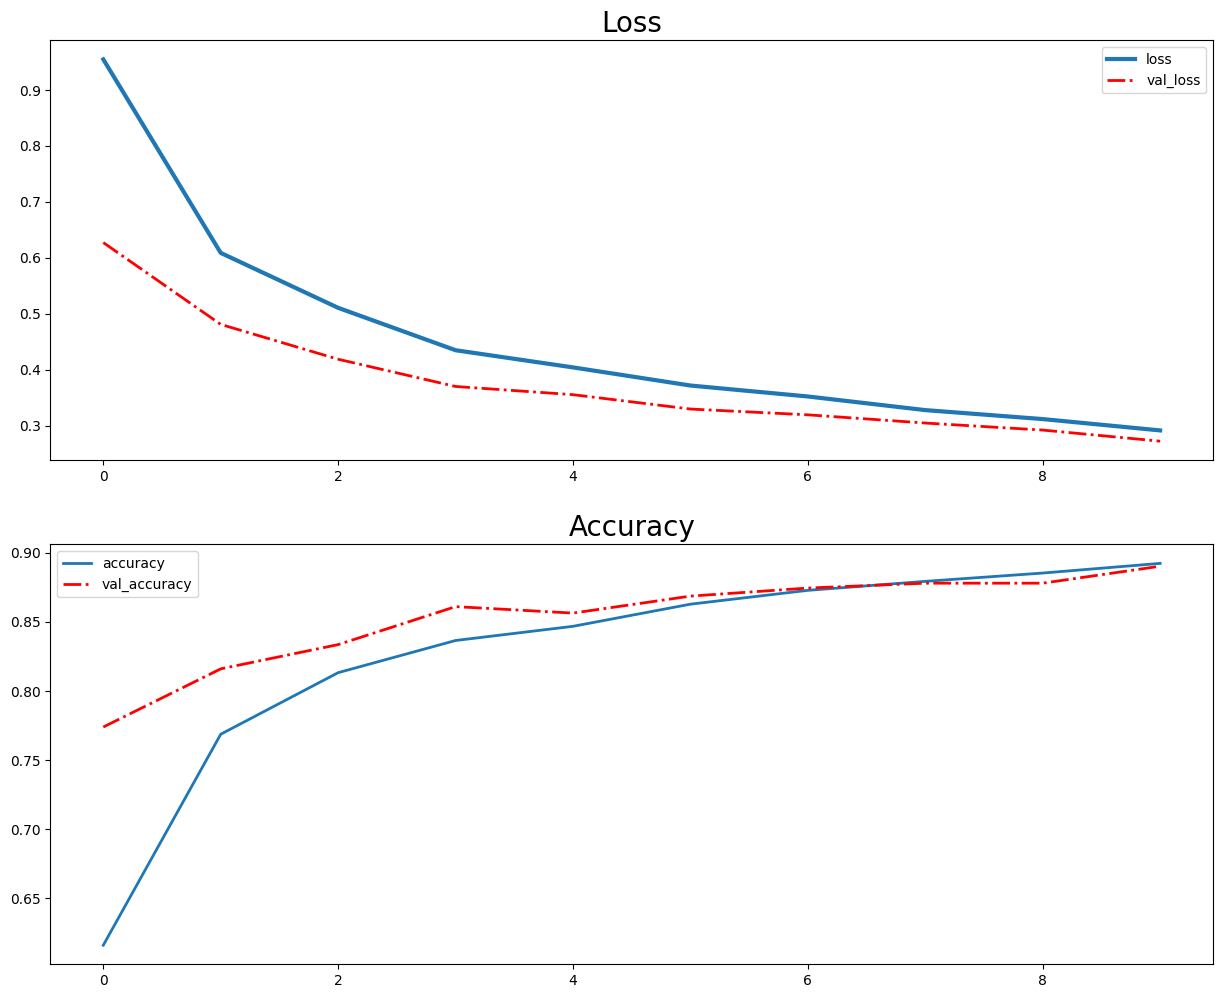

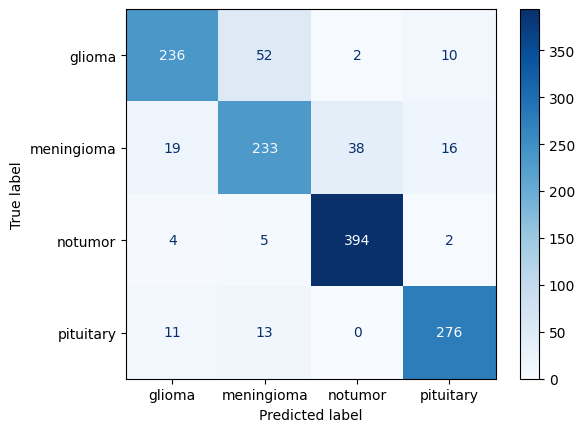

Classification Report
              precision    recall  f1-score   support

           0    0.87407   0.78667   0.82807       300
           1    0.76898   0.76144   0.76519       306
           2    0.90783   0.97284   0.93921       405
           3    0.90789   0.92000   0.91391       300

    accuracy                        0.86880      1311
   macro avg    0.86469   0.86024   0.86159      1311
weighted avg    0.86771   0.86880   0.86737      1311



In [41]:
model_name = 'efficientnetv2m_standart_not_trainable'
input_shape = (256,256,3)

std_m_nt = build_model_not_trainable(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_nt, history_std_m_nt = train(std_m_nt, model_name, train_ds, valid_ds, EPOCHS, SAVE_DIRECTORY)
history_std_m_nt, test_loss, test_acc, test_f1score = plot(std_m_nt, history_std_m_nt)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

## Augmentation

In [42]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomTranslation(0.15, 0.15)
])

In [43]:
def augmentation_train(image, label):
    image = preprocess_input(image)
    image = data_augmentation(image)
    return image, label

def preprocess_val(image, label):
    image = preprocess_input(image)
    return image, label

In [44]:
train_aug = train_ds.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

In [45]:
train_aug = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### EfficientNetV2B0

#### trainable first25

Epoch 1/10


2024-10-16 03:17:30.606374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.7335 - f1_score: 0.7239

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 38s 98ms/step - loss: 0.6598 - accuracy: 0.7335 - f1_score: 0.7239 - val_loss: 0.2547 - val_accuracy: 0.9112 - val_f1_score: 0.9060 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 10s 82ms/step - loss: 0.2383 - accuracy: 0.9218 - f1_score: 0.9197 - val_loss: 0.1239 - val_accuracy: 0.9539 - val_f1_score: 0.9511 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 9s 74ms/step - loss: 0.1115 - accuracy: 0.9620 - f1_score: 0.9609 - val_loss: 0.2262 - val_accuracy: 0.9229 - val_f1_score: 0.9162 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 10s 80ms/step - loss: 0.0727 - accuracy: 0.9753 - f1_score: 0.9745 - val_loss: 0.1024 - val_accuracy: 0.9673 - val_f1_score: 0.9663 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 10s 80ms/step - loss: 0.0294 - accuracy: 0.9925 - f1_score: 0.9922 - val_loss: 0.0830 - val_accuracy: 0.9737 - val_f1_score: 0.9721 - lr: 1.0000e-

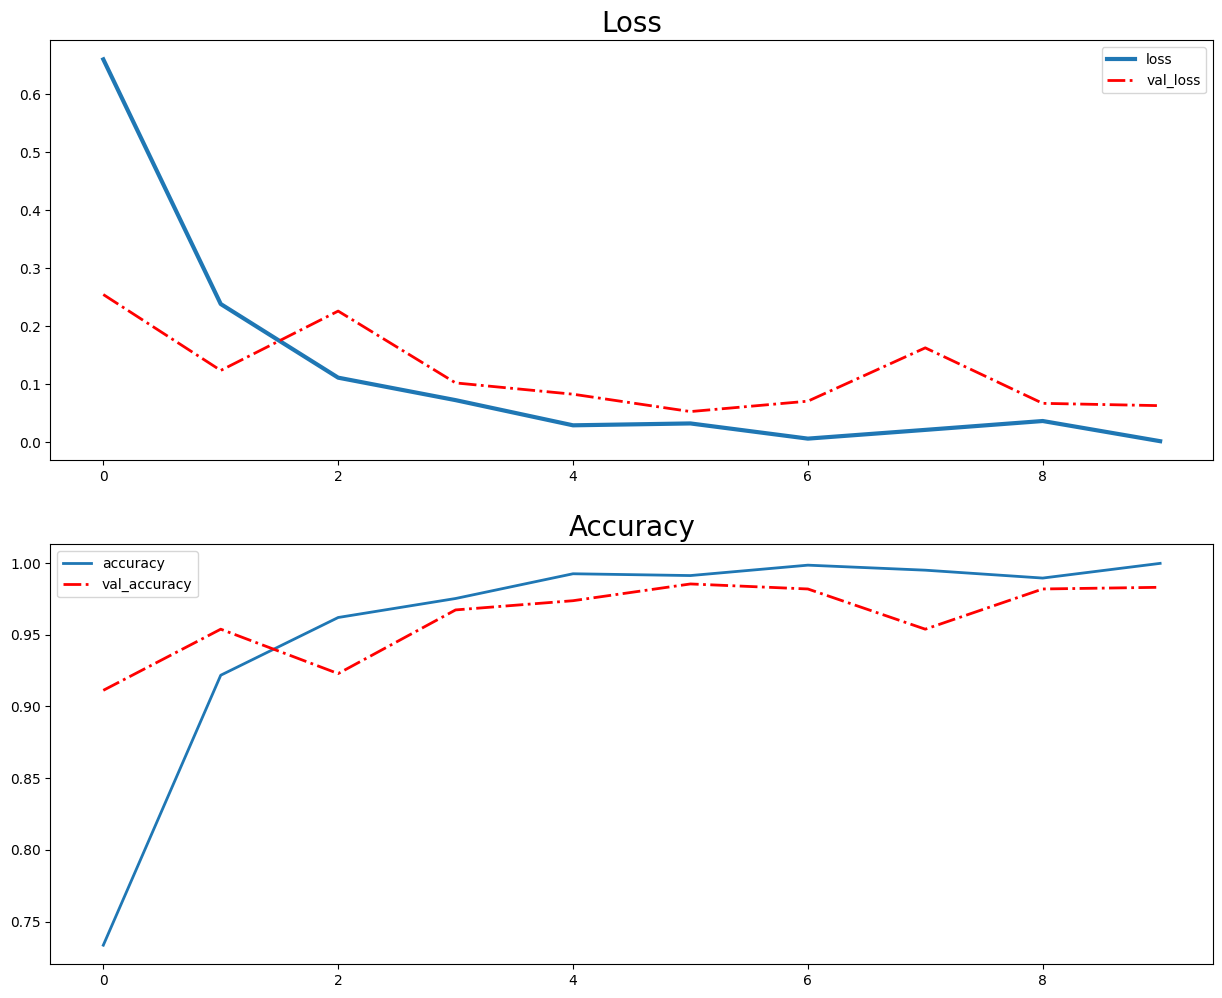

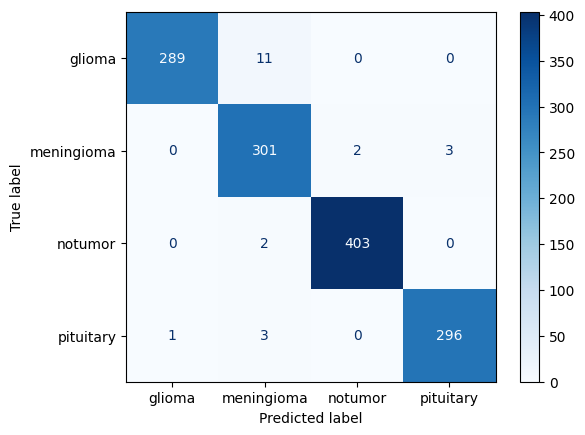

Classification Report
              precision    recall  f1-score   support

           0    0.99655   0.96333   0.97966       300
           1    0.94953   0.98366   0.96629       306
           2    0.99506   0.99506   0.99506       405
           3    0.98997   0.98667   0.98831       300

    accuracy                        0.98322      1311
   macro avg    0.98278   0.98218   0.98233      1311
weighted avg    0.98361   0.98322   0.98328      1311



In [46]:
model_name = 'efficientnetv2b0_augmentation_trainable_first25'
input_shape = (256,256,3)

aug_b0_tf25 = build_model_trainable_first25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_tf25, history_aug_b0_tf25 = train(aug_b0_tf25, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_b0_tf25, test_loss, test_acc, test_f1score = plot(aug_b0_tf25, history_aug_b0_tf25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### trainable last25

Epoch 1/10


2024-10-16 03:19:45.530890: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.7467 - f1_score: 0.7375

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 18s 57ms/step - loss: 0.6376 - accuracy: 0.7467 - f1_score: 0.7375 - val_loss: 0.2416 - val_accuracy: 0.9147 - val_f1_score: 0.9108 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 6s 46ms/step - loss: 0.2509 - accuracy: 0.9150 - f1_score: 0.9124 - val_loss: 0.1529 - val_accuracy: 0.9486 - val_f1_score: 0.9451 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 6s 47ms/step - loss: 0.1437 - accuracy: 0.9467 - f1_score: 0.9453 - val_loss: 0.1363 - val_accuracy: 0.9585 - val_f1_score: 0.9561 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 6s 48ms/step - loss: 0.0769 - accuracy: 0.9745 - f1_score: 0.9738 - val_loss: 0.1034 - val_accuracy: 0.9667 - val_f1_score: 0.9645 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 6s 45ms/step - loss: 0.0423 - accuracy: 0.9875 - f1_score: 0.9872 - val_loss: 0.1438 - val_accuracy: 0.9568 - val_f1_score: 0.9545 - lr: 1.0000e-04


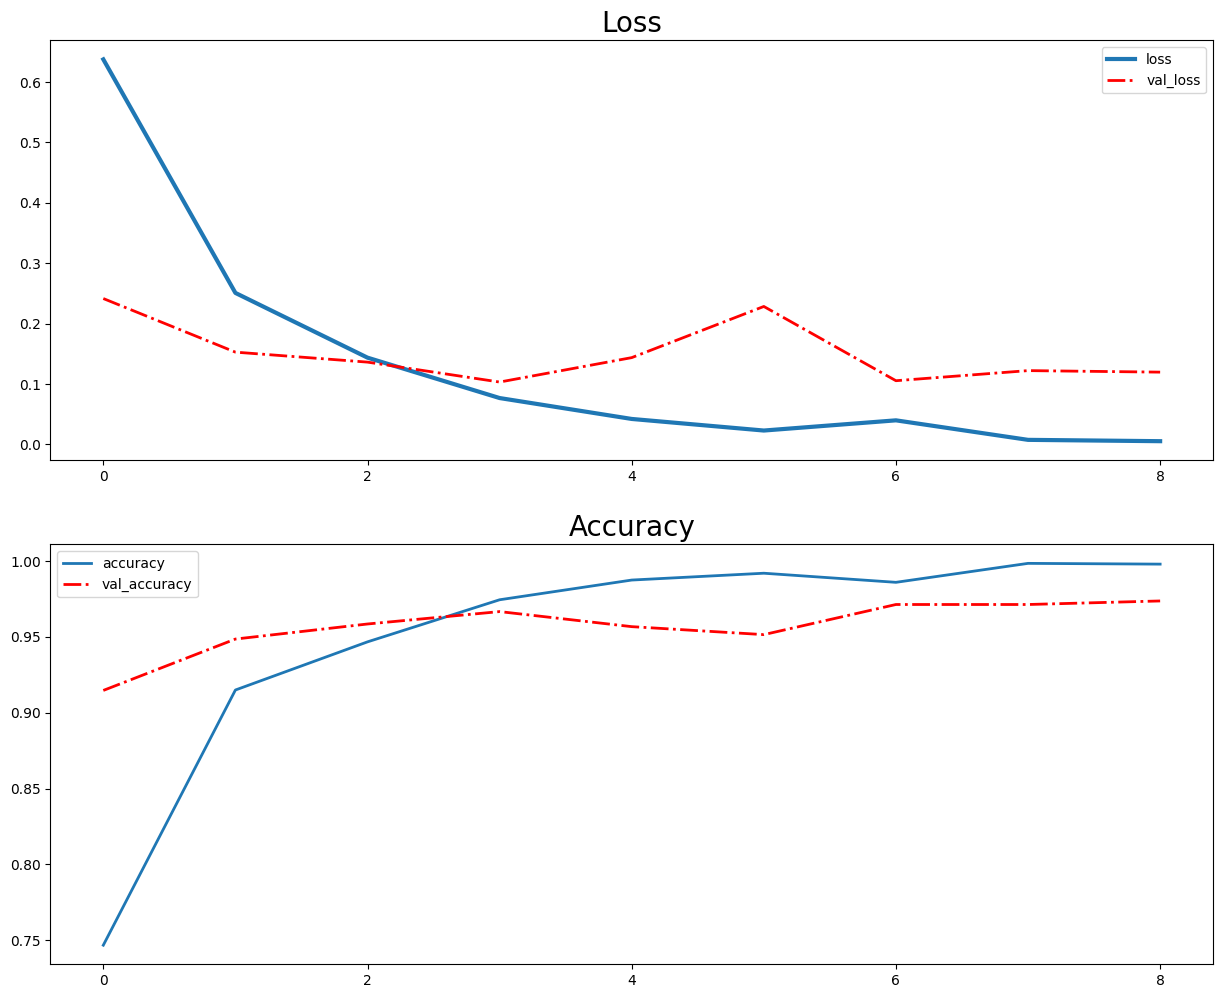

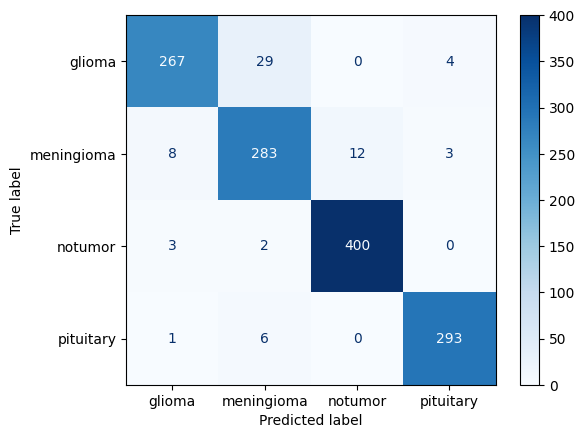

Classification Report
              precision    recall  f1-score   support

           0    0.95699   0.89000   0.92228       300
           1    0.88438   0.92484   0.90415       306
           2    0.97087   0.98765   0.97919       405
           3    0.97667   0.97667   0.97667       300

    accuracy                        0.94813      1311
   macro avg    0.94723   0.94479   0.94557      1311
weighted avg    0.94883   0.94813   0.94808      1311



In [47]:
model_name = 'efficientnetv2b0_augmentation_trainable_last25'
input_shape = (256,256,3)

aug_b0_tl25 = build_model_trainable_last25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_tl25, history_aug_b0_tl25 = train(aug_b0_tl25, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_b0_tl25, test_loss, test_acc, test_f1score = plot(aug_b0_tl25, history_aug_b0_tl25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### not trainable

Epoch 1/10
124/125 [============================>.] - ETA: 0s - loss: 0.9502 - accuracy: 0.6129 - f1_score: 0.5975

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 11s 43ms/step - loss: 0.9483 - accuracy: 0.6137 - f1_score: 0.5985 - val_loss: 0.5621 - val_accuracy: 0.8113 - val_f1_score: 0.7903 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 4s 31ms/step - loss: 0.5529 - accuracy: 0.8035 - f1_score: 0.7953 - val_loss: 0.3744 - val_accuracy: 0.8709 - val_f1_score: 0.8604 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 4s 32ms/step - loss: 0.4331 - accuracy: 0.8425 - f1_score: 0.8376 - val_loss: 0.3117 - val_accuracy: 0.8937 - val_f1_score: 0.8858 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 4s 32ms/step - loss: 0.3745 - accuracy: 0.8662 - f1_score: 0.8614 - val_loss: 0.2819 - val_accuracy: 0.9013 - val_f1_score: 0.8935 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 4s 32ms/step - loss: 0.3407 - accuracy: 0.8748 - f1_score: 0.8700 - val_loss: 0.2532 - val_accuracy: 0.9065 - val_f1_score: 0.9004 - lr: 1.0000e-04


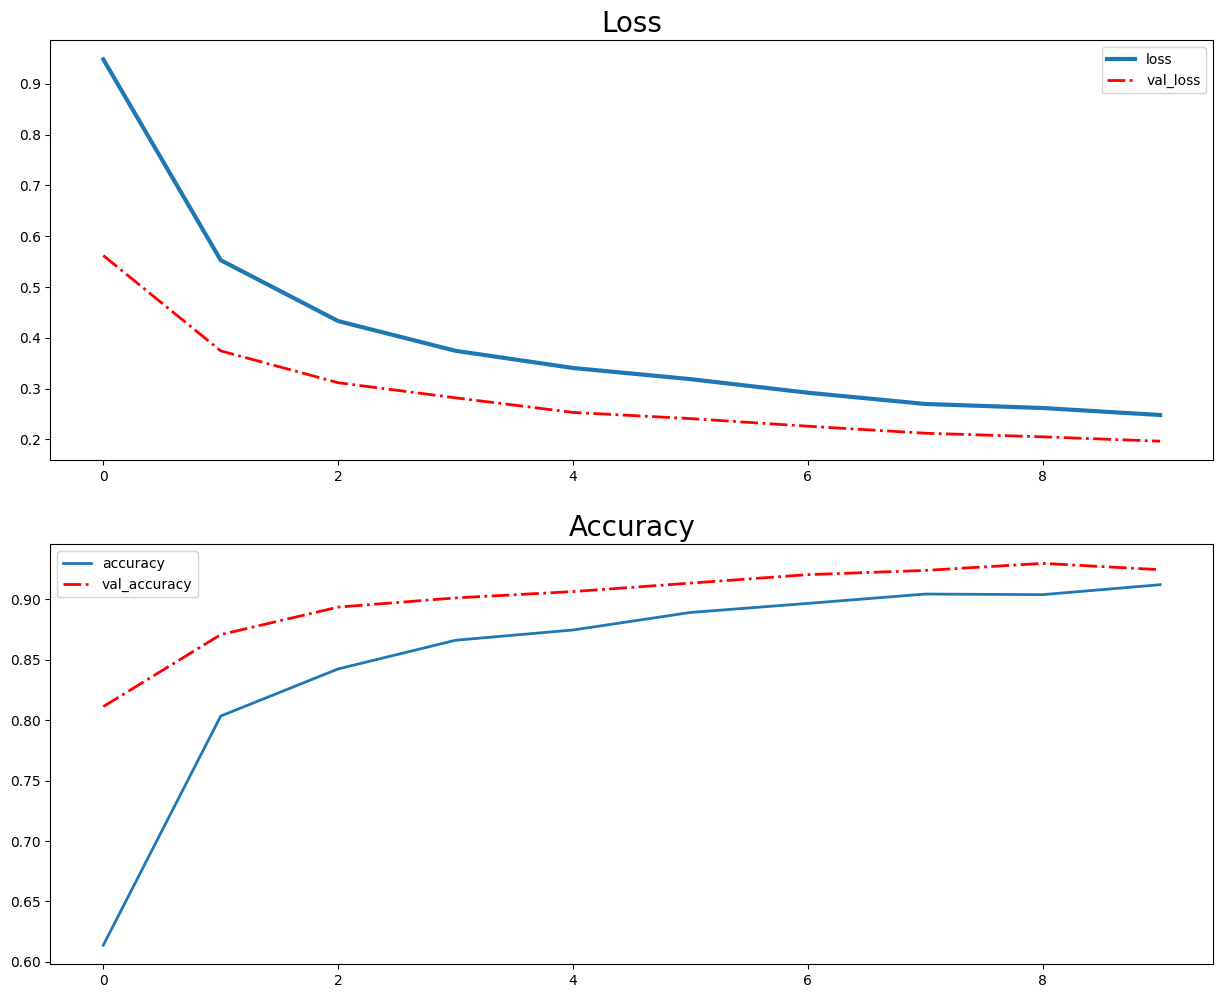

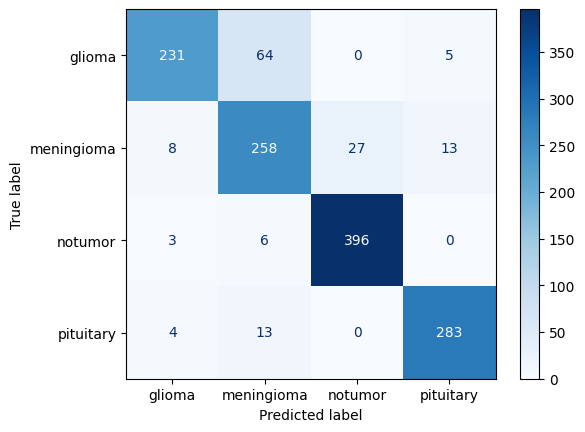

Classification Report
              precision    recall  f1-score   support

           0    0.93902   0.77000   0.84615       300
           1    0.75660   0.84314   0.79753       306
           2    0.93617   0.97778   0.95652       405
           3    0.94020   0.94333   0.94176       300

    accuracy                        0.89092      1311
   macro avg    0.89300   0.88356   0.88549      1311
weighted avg    0.89583   0.89092   0.89078      1311



In [48]:
model_name = 'efficientnetv2b0_augmentation_not_trainable'
input_shape = (256,256,3)

aug_b0_nt = build_model_not_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_nt, history_aug_b0_nt = train(aug_b0_nt, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_b0_nt, test_loss, test_acc, test_f1score = plot(aug_b0_nt, history_aug_b0_nt)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

### EfficientNetV2B3

#### trainable first25

Epoch 1/10


2024-10-16 03:22:06.981450: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.5910 - accuracy: 0.7795 - f1_score: 0.7727

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 55s 142ms/step - loss: 0.5910 - accuracy: 0.7795 - f1_score: 0.7727 - val_loss: 0.2088 - val_accuracy: 0.9223 - val_f1_score: 0.9171 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 16s 127ms/step - loss: 0.1762 - accuracy: 0.9423 - f1_score: 0.9405 - val_loss: 0.1446 - val_accuracy: 0.9533 - val_f1_score: 0.9509 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 16s 125ms/step - loss: 0.0877 - accuracy: 0.9712 - f1_score: 0.9703 - val_loss: 0.0908 - val_accuracy: 0.9737 - val_f1_score: 0.9721 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 16s 129ms/step - loss: 0.0370 - accuracy: 0.9870 - f1_score: 0.9868 - val_loss: 0.0432 - val_accuracy: 0.9831 - val_f1_score: 0.9819 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 14s 112ms/step - loss: 0.0152 - accuracy: 0.9948 - f1_score: 0.9947 - val_loss: 0.0637 - val_accuracy: 0.9784 - val_f1_score: 0.9772 - lr: 1.

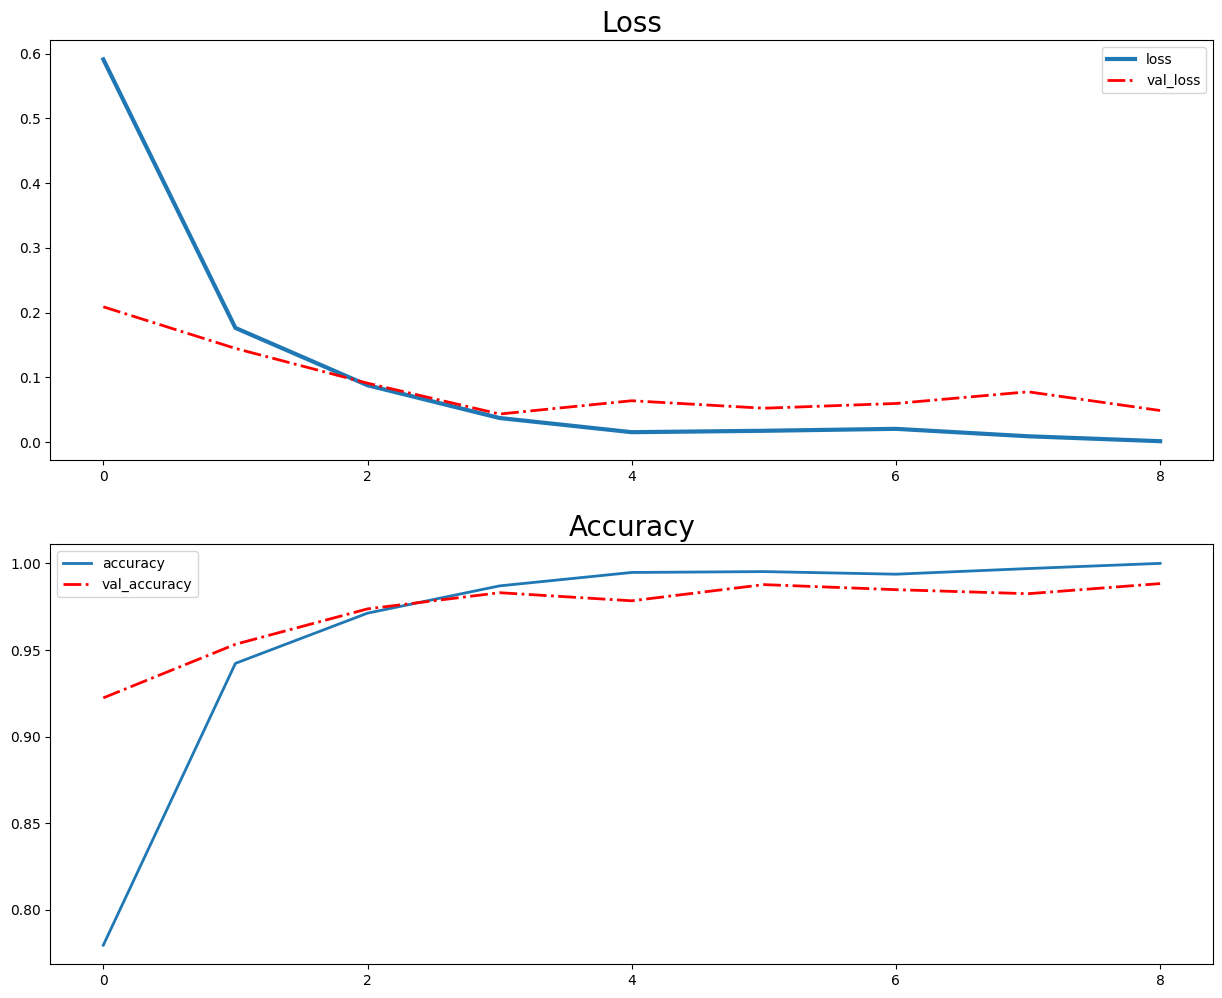

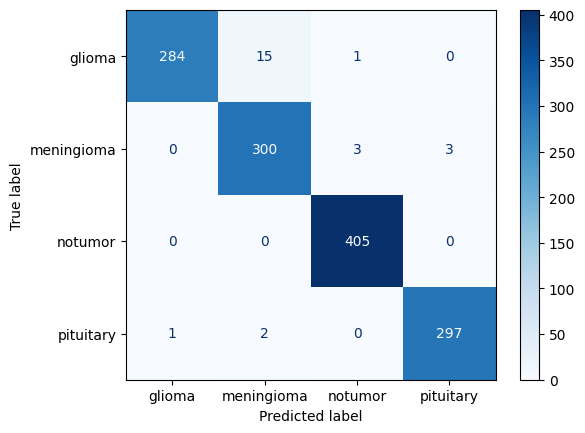

Classification Report
              precision    recall  f1-score   support

           0    0.99649   0.94667   0.97094       300
           1    0.94637   0.98039   0.96308       306
           2    0.99022   1.00000   0.99509       405
           3    0.99000   0.99000   0.99000       300

    accuracy                        0.98093      1311
   macro avg    0.98077   0.97926   0.97978      1311
weighted avg    0.98137   0.98093   0.98093      1311



In [49]:
model_name = 'efficientnetv2b3_augmentation_trainable_first25'
input_shape = (256,256,3)

aug_b3_tf25 = build_model_trainable_first25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_tf25, history_aug_b3_tf25 = train(aug_b3_tf25, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_b3_tf25, test_loss, test_acc, test_f1score = plot(aug_b3_tf25, history_aug_b3_tf25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### trainable last25

Epoch 1/10


2024-10-16 03:25:15.997071: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/dropout_26/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.5530 - accuracy: 0.7790 - f1_score: 0.7712

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 29s 92ms/step - loss: 0.5530 - accuracy: 0.7790 - f1_score: 0.7712 - val_loss: 0.2549 - val_accuracy: 0.8989 - val_f1_score: 0.8943 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 8s 64ms/step - loss: 0.1894 - accuracy: 0.9358 - f1_score: 0.9340 - val_loss: 0.1267 - val_accuracy: 0.9527 - val_f1_score: 0.9498 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 8s 63ms/step - loss: 0.0827 - accuracy: 0.9685 - f1_score: 0.9676 - val_loss: 0.1123 - val_accuracy: 0.9650 - val_f1_score: 0.9630 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 8s 64ms/step - loss: 0.0468 - accuracy: 0.9847 - f1_score: 0.9841 - val_loss: 0.0917 - val_accuracy: 0.9714 - val_f1_score: 0.9697 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 7s 57ms/step - loss: 0.0418 - accuracy: 0.9868 - f1_score: 0.9864 - val_loss: 0.1448 - val_accuracy: 0.9574 - val_f1_score: 0.9543 - lr: 1.0000e-04


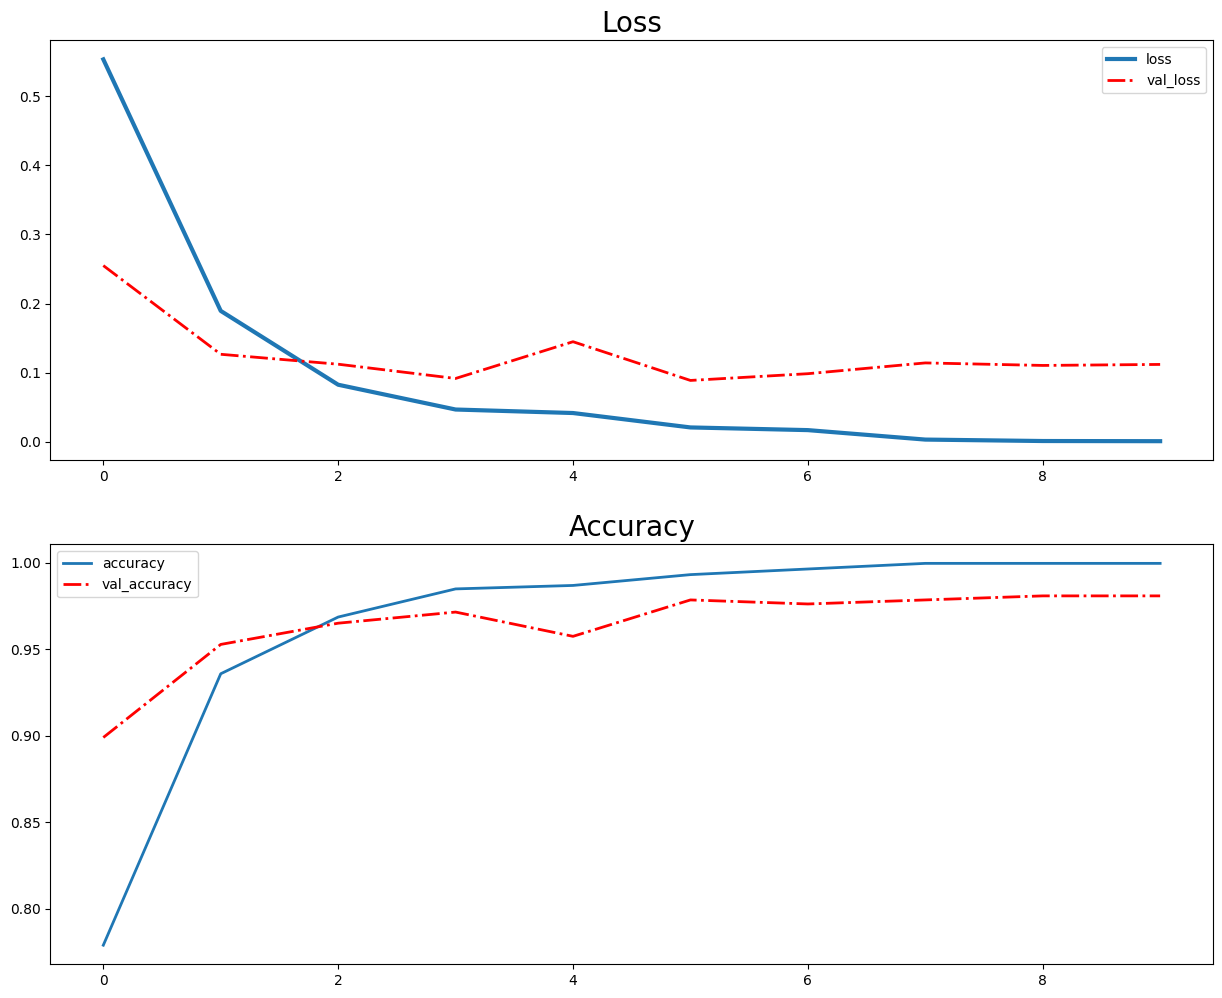

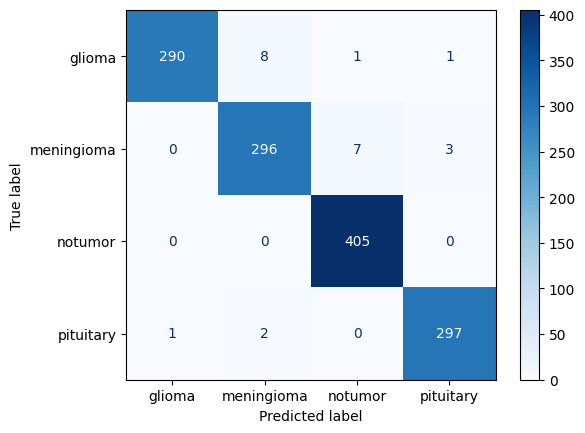

Classification Report
              precision    recall  f1-score   support

           0    0.99656   0.96667   0.98139       300
           1    0.96732   0.96732   0.96732       306
           2    0.98063   1.00000   0.99022       405
           3    0.98671   0.99000   0.98835       300

    accuracy                        0.98246      1311
   macro avg    0.98281   0.98100   0.98182      1311
weighted avg    0.98256   0.98246   0.98243      1311



In [50]:
model_name = 'efficientnetv2m_augmentation_trainable_last25'
input_shape = (256,256,3)

aug_b3_tl25 = build_model_trainable_last25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_tl25, history_aug_b3_tl25 = train(aug_b3_tl25, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_b3_tl25, test_loss, test_acc, test_f1score = plot(aug_b3_tl25, history_aug_b3_tl25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### not trainable

Epoch 1/10
124/125 [============================>.] - ETA: 0s - loss: 0.8794 - accuracy: 0.6436 - f1_score: 0.6282

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 15s 61ms/step - loss: 0.8765 - accuracy: 0.6447 - f1_score: 0.6291 - val_loss: 0.5109 - val_accuracy: 0.8306 - val_f1_score: 0.8206 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 5s 43ms/step - loss: 0.5040 - accuracy: 0.8175 - f1_score: 0.8112 - val_loss: 0.3639 - val_accuracy: 0.8779 - val_f1_score: 0.8683 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 5s 43ms/step - loss: 0.4043 - accuracy: 0.8547 - f1_score: 0.8490 - val_loss: 0.3173 - val_accuracy: 0.8867 - val_f1_score: 0.8806 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 6s 45ms/step - loss: 0.3541 - accuracy: 0.8717 - f1_score: 0.8675 - val_loss: 0.2841 - val_accuracy: 0.8978 - val_f1_score: 0.8925 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 6s 45ms/step - loss: 0.3222 - accuracy: 0.8767 - f1_score: 0.8728 - val_loss: 0.2572 - val_accuracy: 0.9036 - val_f1_score: 0.8976 - lr: 1.0000e-04


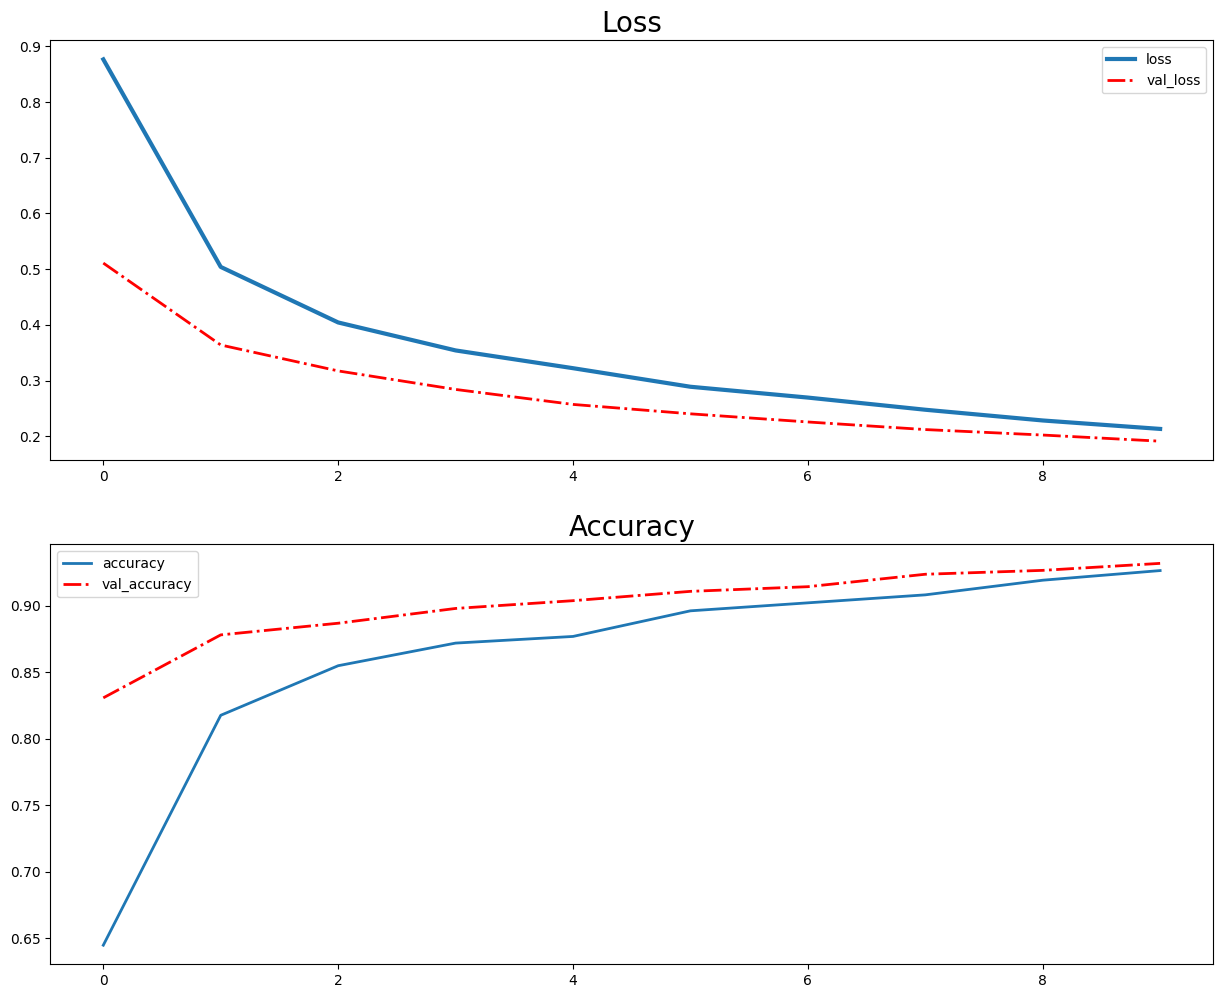

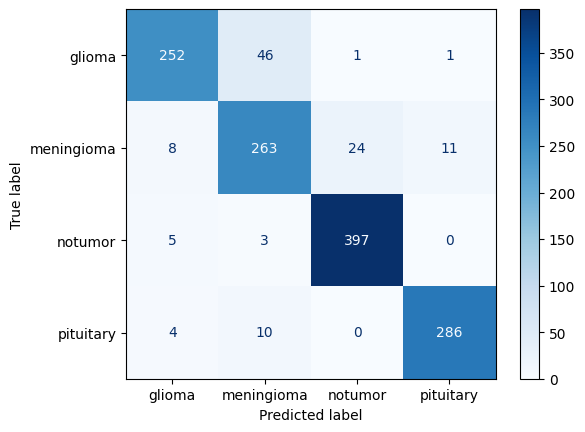

Classification Report
              precision    recall  f1-score   support

           0    0.93680   0.84000   0.88576       300
           1    0.81677   0.85948   0.83758       306
           2    0.94076   0.98025   0.96010       405
           3    0.95973   0.95333   0.95652       300

    accuracy                        0.91381      1311
   macro avg    0.91352   0.90826   0.90999      1311
weighted avg    0.91525   0.91381   0.91367      1311



In [51]:
model_name = 'efficientnetv2b3_augmentation_not_trainable'
input_shape = (256,256,3)
aug_b3_nt = build_model_not_trainable(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_nt, history_aug_b3_nt = train(aug_b3_nt, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_b3_nt, test_loss, test_acc, test_f1score = plot(aug_b3_nt, history_aug_b3_nt)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

### EfficientNetV2M

#### trainable first25

Epoch 1/10


2024-10-16 03:28:49.491442: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_15/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.5972 - accuracy: 0.7825 - f1_score: 0.7795

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 132s 277ms/step - loss: 0.5972 - accuracy: 0.7825 - f1_score: 0.7795 - val_loss: 0.1724 - val_accuracy: 0.9457 - val_f1_score: 0.9426 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 26s 210ms/step - loss: 0.1382 - accuracy: 0.9628 - f1_score: 0.9618 - val_loss: 0.1327 - val_accuracy: 0.9562 - val_f1_score: 0.9541 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 27s 218ms/step - loss: 0.0949 - accuracy: 0.9722 - f1_score: 0.9719 - val_loss: 0.1210 - val_accuracy: 0.9632 - val_f1_score: 0.9632 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 26s 205ms/step - loss: 0.0458 - accuracy: 0.9870 - f1_score: 0.9866 - val_loss: 0.0916 - val_accuracy: 0.9778 - val_f1_score: 0.9762 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 28s 222ms/step - loss: 0.0393 - accuracy: 0.9898 - f1_score: 0.9896 - val_loss: 0.0693 - val_accuracy: 0.9819 - val_f1_score: 0.9811 - lr: 1

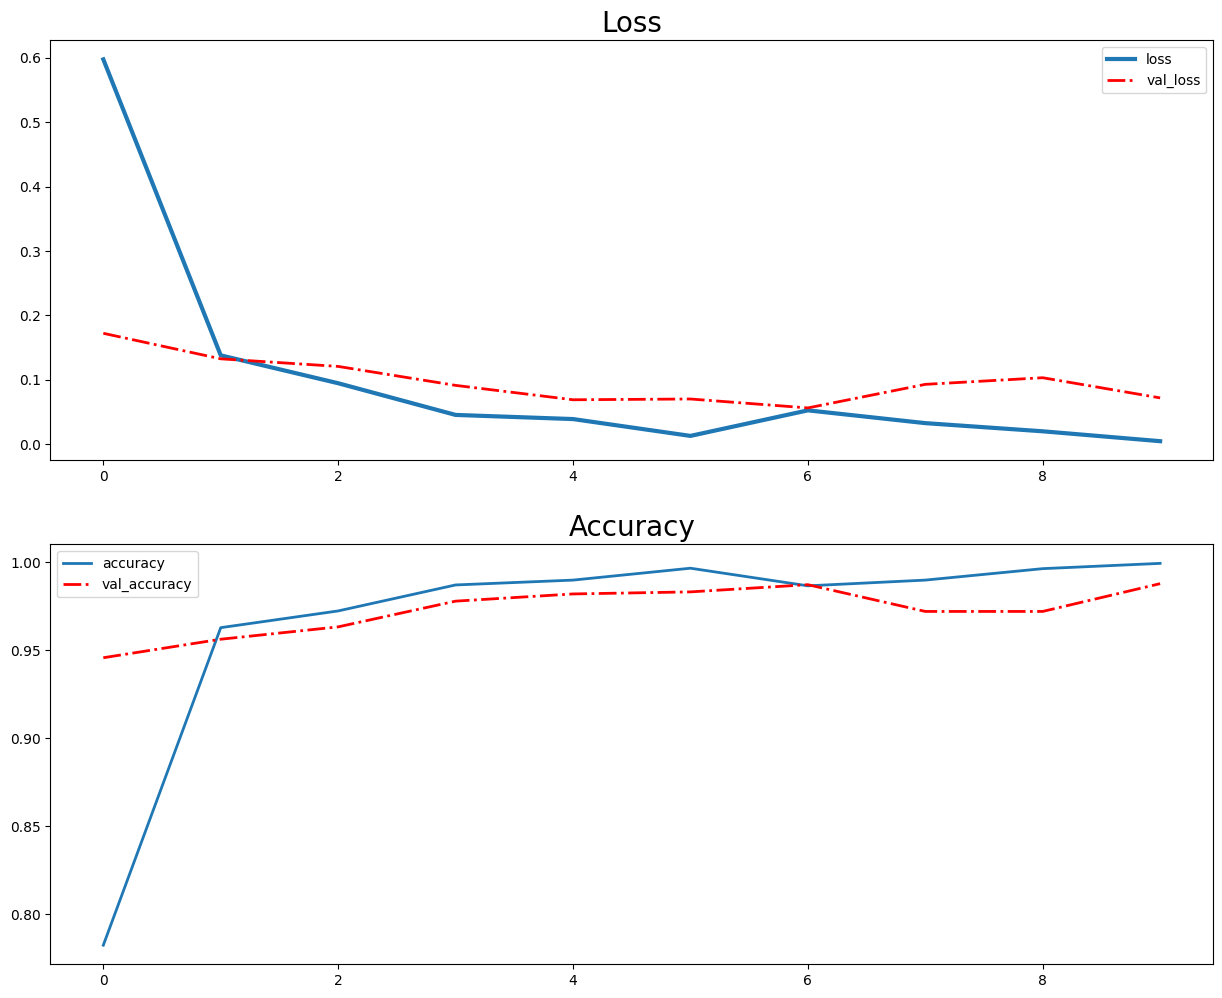

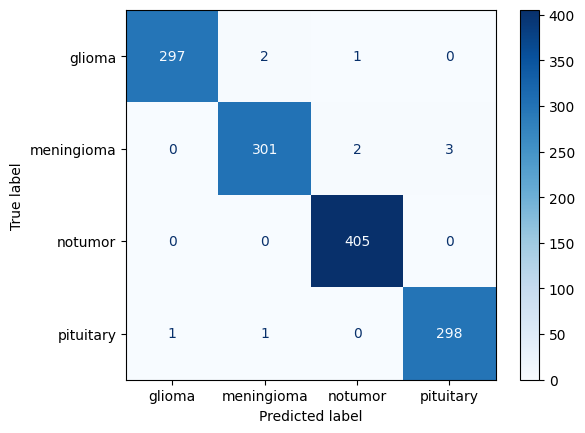

Classification Report
              precision    recall  f1-score   support

           0    0.99664   0.99000   0.99331       300
           1    0.99013   0.98366   0.98689       306
           2    0.99265   1.00000   0.99631       405
           3    0.99003   0.99333   0.99168       300

    accuracy                        0.99237      1311
   macro avg    0.99236   0.99175   0.99205      1311
weighted avg    0.99238   0.99237   0.99236      1311



In [52]:
model_name = 'efficientnetv2m_augmentation_trainable_first25'
input_shape = (256,256,3)

aug_m_tf25 = build_model_trainable_first25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_tf25, history_aug_m_tf25 = train(aug_m_tf25, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_m_tf25, test_loss, test_acc, test_f1score = plot(aug_m_tf25, history_aug_m_tf25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### trainable last25

Epoch 1/10


2024-10-16 03:34:56.792428: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_16/dropout_32/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - ETA: 0s - loss: 0.4755 - accuracy: 0.8188 - f1_score: 0.8137

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 52s 163ms/step - loss: 0.4755 - accuracy: 0.8188 - f1_score: 0.8137 - val_loss: 0.2133 - val_accuracy: 0.9206 - val_f1_score: 0.9158 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 16s 127ms/step - loss: 0.1438 - accuracy: 0.9503 - f1_score: 0.9488 - val_loss: 0.2394 - val_accuracy: 0.9305 - val_f1_score: 0.9281 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 15s 122ms/step - loss: 0.0936 - accuracy: 0.9670 - f1_score: 0.9659 - val_loss: 0.1442 - val_accuracy: 0.9492 - val_f1_score: 0.9443 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 15s 120ms/step - loss: 0.0862 - accuracy: 0.9728 - f1_score: 0.9720 - val_loss: 0.0776 - val_accuracy: 0.9761 - val_f1_score: 0.9745 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 15s 117ms/step - loss: 0.0377 - accuracy: 0.9868 - f1_score: 0.9863 - val_loss: 0.0748 - val_accuracy: 0.9790 - val_f1_score: 0.9776 - lr: 1.

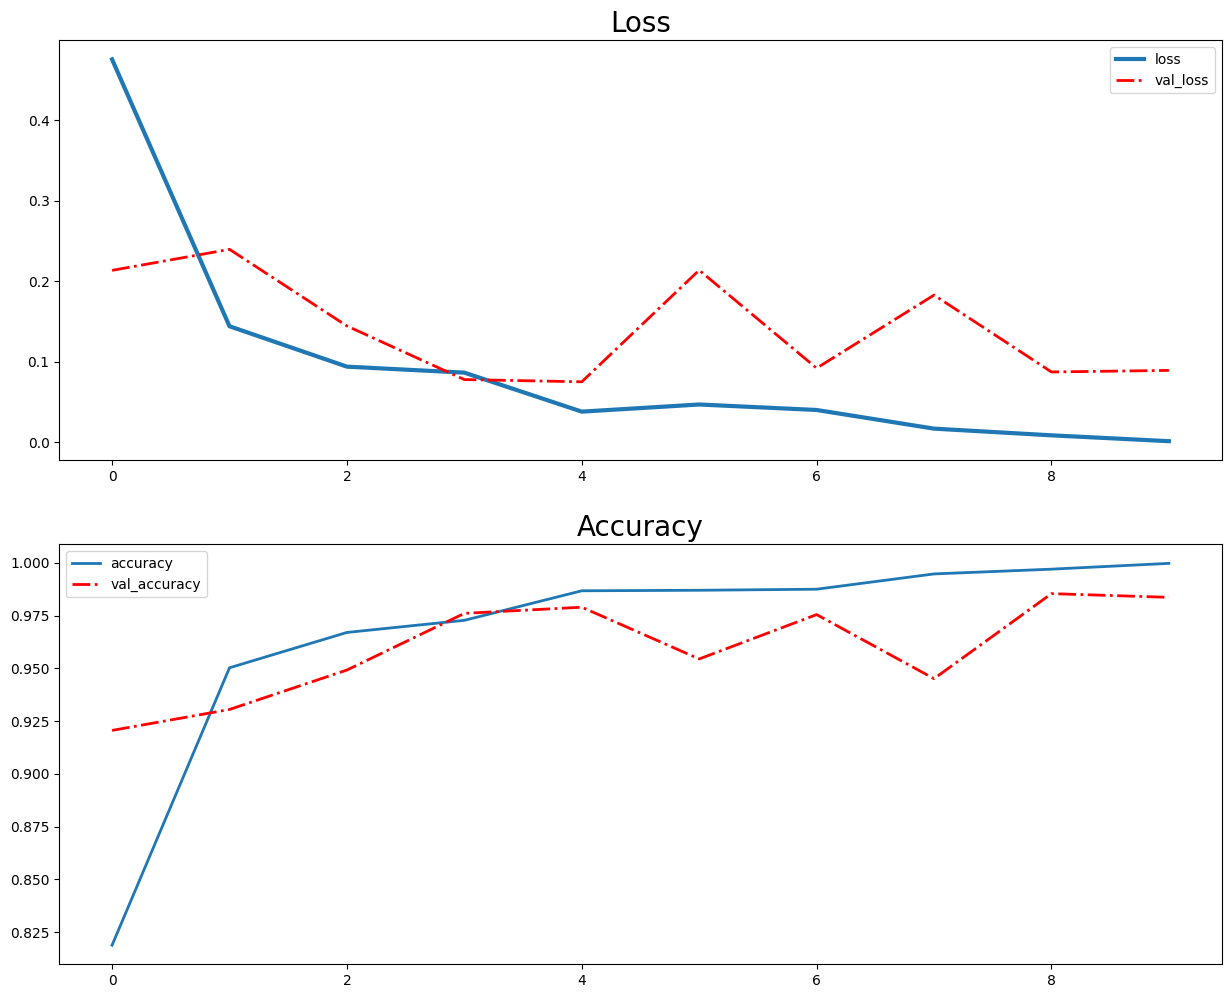

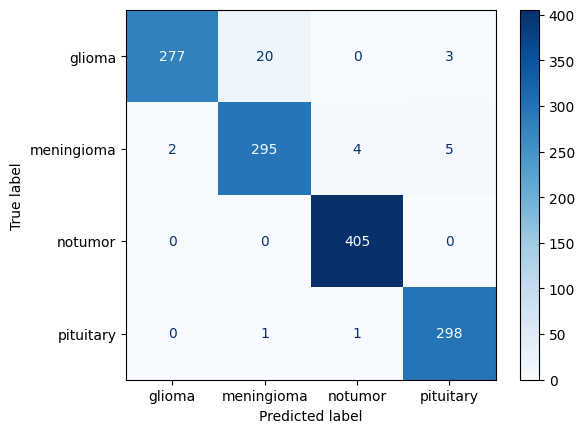

Classification Report
              precision    recall  f1-score   support

           0    0.99283   0.92333   0.95682       300
           1    0.93354   0.96405   0.94855       306
           2    0.98780   1.00000   0.99387       405
           3    0.97386   0.99333   0.98350       300

    accuracy                        0.97254      1311
   macro avg    0.97201   0.97018   0.97068      1311
weighted avg    0.97310   0.97254   0.97244      1311



In [53]:
model_name = 'efficientnetv2m_augmentation_trainable_last25'
input_shape = (256,256,3)

aug_m_tl25 = build_model_trainable_last25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_tl25, history_aug_m_tl25 = train(aug_m_tl25, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_m_tl25, test_loss, test_acc, test_f1score = plot(aug_m_tl25, history_aug_m_tl25)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

#### not trainable

Epoch 1/10
124/125 [============================>.] - ETA: 0s - loss: 0.9313 - accuracy: 0.6305 - f1_score: 0.6129

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 31s 114ms/step - loss: 0.9290 - accuracy: 0.6315 - f1_score: 0.6142 - val_loss: 0.5995 - val_accuracy: 0.7932 - val_f1_score: 0.7794 - lr: 1.0000e-04
Epoch 2/10
125/125 [==============================] - 10s 80ms/step - loss: 0.5962 - accuracy: 0.7682 - f1_score: 0.7600 - val_loss: 0.4711 - val_accuracy: 0.8277 - val_f1_score: 0.8182 - lr: 1.0000e-04
Epoch 3/10
125/125 [==============================] - 10s 81ms/step - loss: 0.4990 - accuracy: 0.8120 - f1_score: 0.8050 - val_loss: 0.4026 - val_accuracy: 0.8499 - val_f1_score: 0.8401 - lr: 1.0000e-04
Epoch 4/10
125/125 [==============================] - 10s 78ms/step - loss: 0.4377 - accuracy: 0.8307 - f1_score: 0.8244 - val_loss: 0.3714 - val_accuracy: 0.8563 - val_f1_score: 0.8473 - lr: 1.0000e-04
Epoch 5/10
125/125 [==============================] - 10s 80ms/step - loss: 0.4081 - accuracy: 0.8518 - f1_score: 0.8469 - val_loss: 0.3398 - val_accuracy: 0.8709 - val_f1_score: 0.8615 - lr: 1.0000

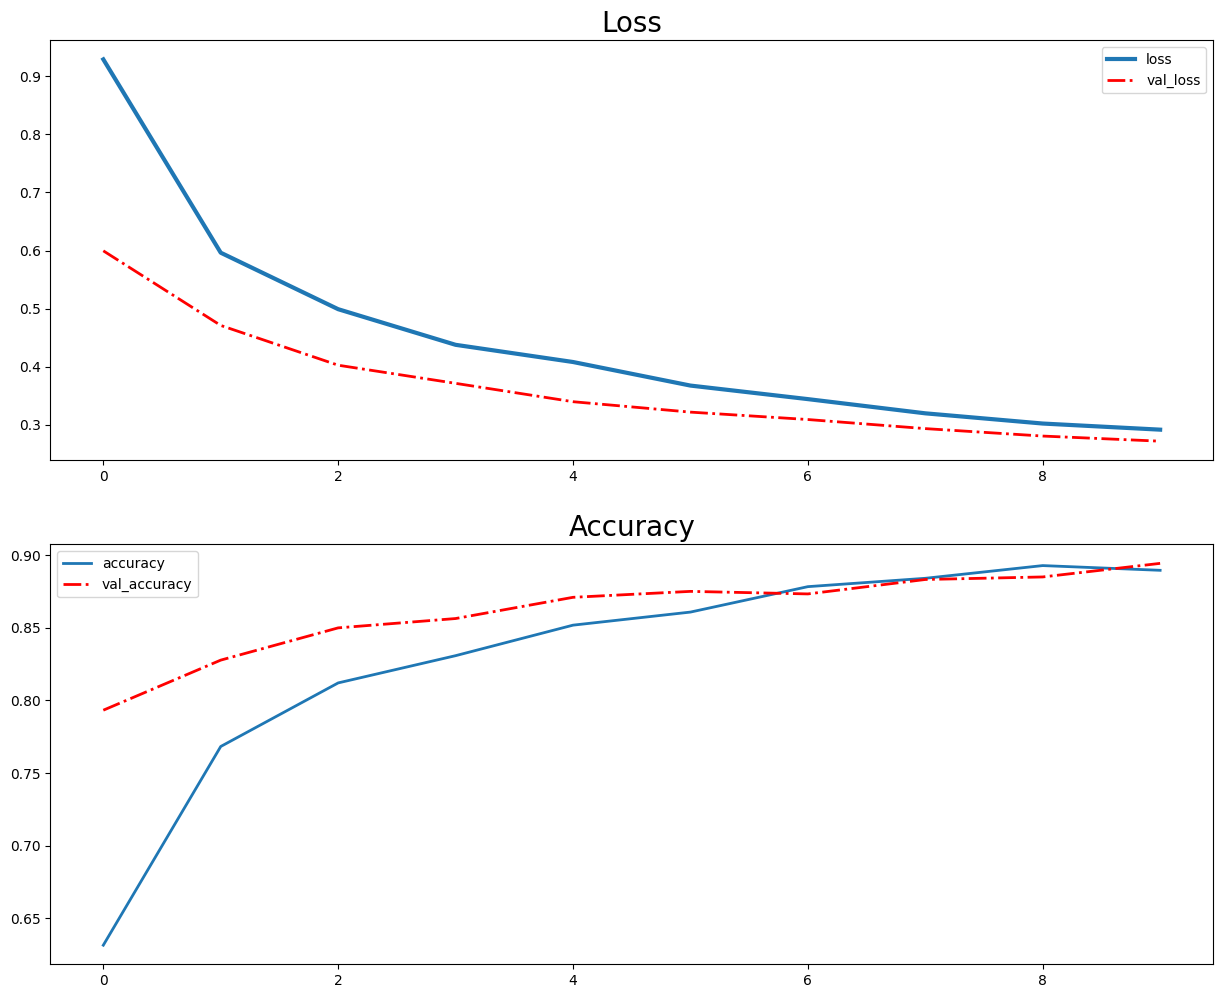

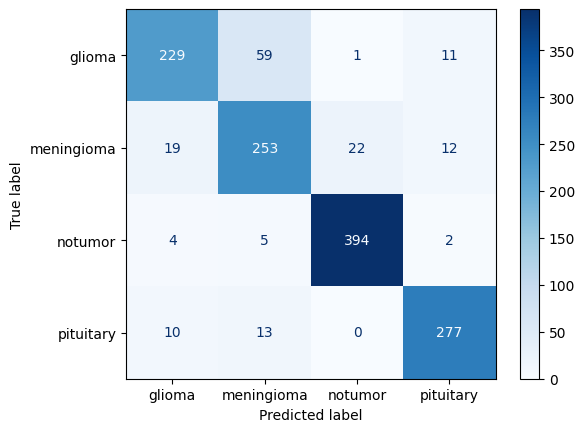

Classification Report
              precision    recall  f1-score   support

           0    0.87405   0.76333   0.81495       300
           1    0.76667   0.82680   0.79560       306
           2    0.94484   0.97284   0.95864       405
           3    0.91722   0.92333   0.92027       300

    accuracy                        0.87948      1311
   macro avg    0.87569   0.87158   0.87236      1311
weighted avg    0.88073   0.87948   0.87892      1311



In [54]:
model_name = 'efficientnetv2m_augmentation_not_trainable'
input_shape = (256,256,3)

aug_m_nt = build_model_not_trainable(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_nt, history_aug_m_nt = train(aug_m_nt, model_name, train_aug, valid_aug, EPOCHS, SAVE_DIRECTORY)
history_aug_m_nt, test_loss, test_acc, test_f1score = plot(aug_m_nt, history_aug_m_nt)
result(model_name, test_loss, test_acc, test_f1score, result_dict)

# Result

In [55]:
results = pd.DataFrame(result_dict)
print(results)

                                         Model Name  Test Loss  Test Accuracy  \
0       efficientnetv2b0_standart_trainable_first25   0.071529       0.983982   
1        efficientnetv2b0_standart_trainable_last25   0.191757       0.934401   
2           efficientnetv2b0_standart_not_trainable   0.294261       0.883295   
3       efficientnetv2b3_standart_trainable_first25   0.051677       0.984744   
4        efficientnetv2b3_standart_trainable_last25   0.097804       0.980168   
5           efficientnetv2b3_standart_not_trainable   0.232988       0.915332   
6        efficientnetv2m_standart_trainable_first25   0.060035       0.986270   
7         efficientnetv2m_standart_trainable_last25   0.152718       0.970252   
8            efficientnetv2m_standart_not_trainable   0.340339       0.868802   
9   efficientnetv2b0_augmentation_trainable_first25   0.067744       0.983219   
10   efficientnetv2b0_augmentation_trainable_last25   0.162386       0.948131   
11      efficientnetv2b0_aug

# Testing using Different Dataset

In [56]:
def evaluate_model_on_dataset(model, dataset, class_names):
    # y_true = []
    # y_pred = []

    # test_loss, test_acc, test_f1score = model.evaluate(test_ds, verbose=1)
    
    # # Iterate over the dataset
    # for images, labels in dataset:
    #     # Get true labels
    #     y_true.extend(np.argmax(labels.numpy(), axis=1))
        
    #     # Predict using the model
    #     predictions = model.predict(images)
    #     y_pred.extend(np.argmax(predictions, axis=1))
    
    # # Ensure y_true and y_pred have the same length
    # assert len(y_true) == len(y_pred), f"Length mismatch: y_true={len(y_true)}, y_pred={len(y_pred)}"
    
    # # Generate confusion matrix
    # cm = confusion_matrix(y_true, y_pred)
    
    # # Plot confusion matrix
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    # plt.xlabel('Predicted Label')
    # plt.ylabel('True Label')
    # plt.title('Confusion Matrix')
    # plt.show()

    # # Generate classification report
    # report = classification_report(y_true, y_pred, target_names=class_names)
    # print(f"Classification Report:\n{report}")




    class_names = sorted(class_names)

    model.evaluate(dataset)

    # Make predictions
    y_pred = []
    y_true = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.show()

    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5)
    print(cr)
    
    return cm, cr

In [60]:
def load_new_dataset(dataset_dir, image_size=(256, 256), batch_size=32):
    dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        labels='inferred',
        label_mode='categorical',  # Assuming the dataset has multiple classes
        class_names=[class_name for class_name in os.listdir(dataset_dir)],
        seed=42,
        image_size=image_size,  # Automatically resizes images to 224x224
        batch_size=batch_size,
        shuffle=False  # Turn off shuffle for evaluation
    )
    return dataset

In [61]:
def load_best_model(model_path):
    return tf.keras.models.load_model(model_path)

Found 3057 files belonging to 4 classes.
1/1 [==============================] - 2s 2s/step


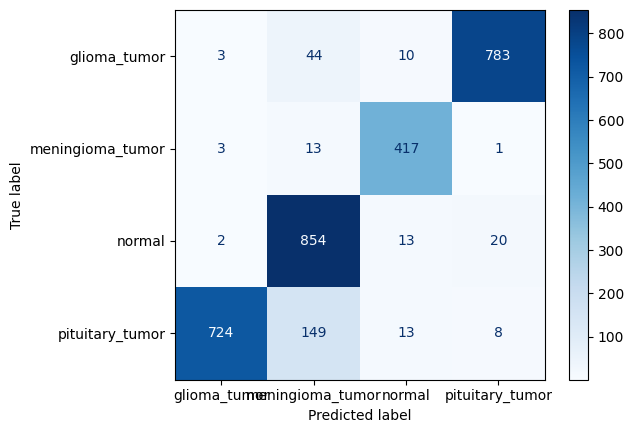

Classification Report
              precision    recall  f1-score   support

           0    0.00410   0.00357   0.00382       840
           1    0.01226   0.02995   0.01740       434
           2    0.02870   0.01462   0.01937       889
           3    0.00985   0.00895   0.00938       894

    accuracy                        0.01210      3057
   macro avg    0.01373   0.01427   0.01249      3057
weighted avg    0.01409   0.01210   0.01190      3057



(array([[  3,  44,  10, 783],
        [  3,  13, 417,   1],
        [  2, 854,  13,  20],
        [724, 149,  13,   8]]),
 '              precision    recall  f1-score   support\n\n           0    0.00410   0.00357   0.00382       840\n           1    0.01226   0.02995   0.01740       434\n           2    0.02870   0.01462   0.01937       889\n           3    0.00985   0.00895   0.00938       894\n\n    accuracy                        0.01210      3057\n   macro avg    0.01373   0.01427   0.01249      3057\nweighted avg    0.01409   0.01210   0.01190      3057\n')

In [67]:
# 1. Load the best model (replace 'path_to_best_model.h5' with the actual model file path)
best_model = load_best_model(CWD+'/model/model_efficientnetv2b0_standart_trainable_last25.h5')

# 2. Load the new dataset (replace 'path_to_new_dataset' with the actual dataset directory)
new_dataset = load_new_dataset(CWD + '/dataset/test')

class_names = new_dataset.class_names

# 4. Evaluate the model and generate confusion matrix and classification report
evaluate_model_on_dataset(best_model, new_dataset, class_names)